Bike sharing case study:  Exploratory Data Analysis and Machine Learning Forecasting  

# I Introduction

The benefits of bike sharing include transport flexibility, reductions of dependence on cars and vehicle emissions,  reduced congestion and fuel consumption, health benefits, and financial savings for individuals, making cities more sustainable, liveable, and accessible for everyone.

we performed some exploratory analysis on the data set 'Bike rentals', which contains historical data of bike sharing system in Washington, D.C. from the beginning of 2011 to the end of 2012. The goals are to combine past rental underlying patterns and characteristics with historical weather data in order to: 
- Identified influential factors.
- Understand users behaviors.
- Understand the underlying patterns and trends in usage.
- Generate a model to forecast future rental demand.
- Extract insights to support: improvement of future data collection and other possible data analysis tasks, future marketing expansion, optimization the management of bikes and stations therefore reinvention of the city transportation system.

In [ ]:
# Import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes",labelweight="bold",labelsize="large",titleweight="bold", titlesize=14,titlepad=10,)
plot_params = dict(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",legend=False,)
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style(style='darkgrid', rc={'axes.facecolor': '.9', 'grid.color': '.8'})
sns.set_palette(palette='husl')
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

import datetime
from scipy.signal import periodogram

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import (StandardScaler, PolynomialFeatures)
from sklearn.model_selection import (train_test_split, GridSearchCV, TimeSeriesSplit)
from sklearn.linear_model import (ElasticNet,LinearRegression)
from sklearn.ensemble import (RandomForestRegressor as RF, GradientBoostingRegressor as GBR)
from sklearn.metrics import (r2_score, mean_squared_error, get_scorer)
import shap
import pickle 


# II Read and understand the data

In [ ]:
bikeshare_hr=pd.read_csv(r'C:\Users\02\Datasets\BikeShareDataset\hour.csv')
df=bikeshare_hr.copy()
df.head(5)
df.tail(5)

instant      dteday  season  yr  mnth  hr  holiday  weekday  \
17374    17375  2012-12-31       1   1    12  19        0        1   
17375    17376  2012-12-31       1   1    12  20        0        1   
17376    17377  2012-12-31       1   1    12  21        0        1   
17377    17378  2012-12-31       1   1    12  22        0        1   
17378    17379  2012-12-31       1   1    12  23        0        1   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
17374           1           2  0.26  0.2576  0.60     0.1642      11   
17375           1           2  0.26  0.2576  0.60     0.1642       8   
17376           1           1  0.26  0.2576  0.60     0.1642       7   
17377           1           1  0.26  0.2727  0.56     0.1343      13   
17378           1           1  0.26  0.2727  0.65     0.1343      12   

       registered  cnt  
17374         108  119  
17375          81   89  
17376          83   90  
17377          48   61  
17378          37   49

In [4]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Insights: most of variables are self-explanatory: 
- instant: record index
- dteday : date
- season : season (1:springer, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit : 1: clear, few clouds; 2: mist + cloudy; 3: light Snow/Rain, thunderstorm 4: Heavy Rain, Snow+Fog
- temp : normalized temperature in Celsius. The values are divided to 41 (max)
- atemp: normalized feeling temperature in Celsius. The values are divided to 50 (max)
- hum: normalized humidity. The values are divided to 100 (max)
- windspeed: normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [5]:
df.shape

(17379, 17)

Insights:
- 17379 rows and 17 columns.
- Target variable y is 'cnt', which is count of bikers.  'cnt' = 'casual'+'registered'. 
- In total, we have 17 features.
- Dataset is well sorted by 'dteday' and 'hr'.
- 'instant' is a irrelevant variable (can be removed or kept in index part). 

# III Data quality check and data cleaning

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [46]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [47]:
df.describe() 

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

In [48]:
df=df.drop_duplicates()
df.shape

(17379, 17)

Insight:
- No null values. 
- No duplicate rows.
- Mean ~ median, apparently numerical features 'temp', 'atemp', 'hum', 'windspeed' have no skewness and outliers. 
- For target variables 'casual', 'registered', 'cnt', mean>median, right skewed. 
- Categorical features are in either float or integer dtype, need to be transformed.
- Date columns 'dteday' is in dtype 'object'.
- No need to rescale predictors.

# IV Exploratory data analysis (EDA)

## IV.1 Explore numeric variables

Firstly explore target variable, afterward other numeric features.

In [17]:
total=df['cnt'].sum()
total_cas=df['casual'].sum()
total_regis=df['registered'].sum()
percentage=[total_cas/(total_cas+total_regis), total_regis/(total_cas+total_regis), 1.0]
df_bikers=pd.DataFrame({'Total': [total_cas, total_regis, total], 'Percentage': percentage}, 
                       index=['Casual','Registered','total'])
df_bikers

Total  Percentage
Casual       620017    0.188302
Registered  2672662    0.811698
total       3292679    1.000000

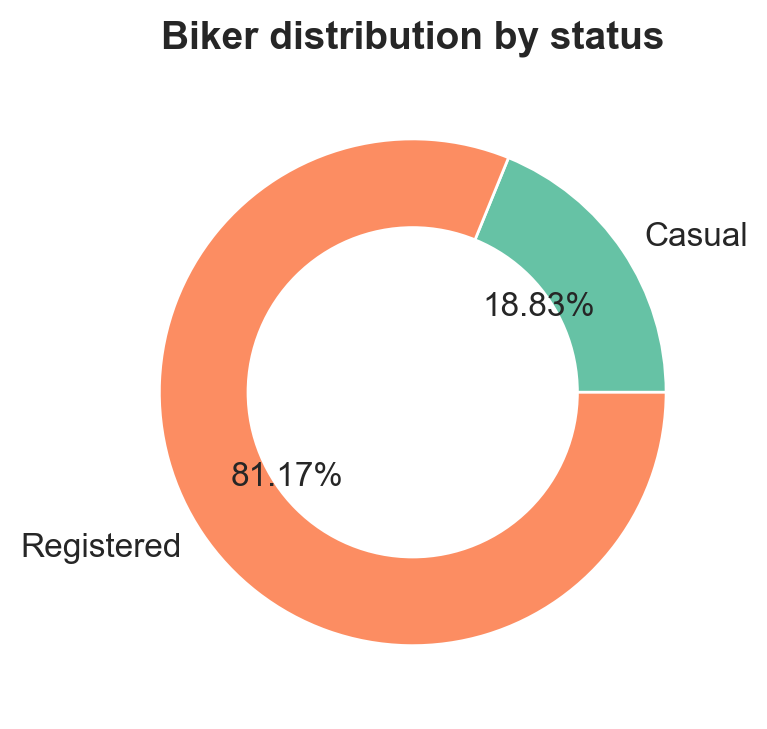

In [26]:
fig, ax = plt.subplots(figsize=(4,4))
ax.pie(percentage[:2], wedgeprops={'linewidth': 1, 'edgecolor': 'white'}, colors=sns.color_palette('Set2'), 
       frame=False, labels=['Casual','Registered'], autopct='%1.2f%%', textprops={'fontsize':12})
plt.title(label= 'Biker distribution by status', fontdict={'fontsize':14}, pad=10)
hole = plt.Circle((0, 0), 0.65, facecolor='white')
plt.gcf().gca().add_artist(hole)
# chart can be improved, add 'hue'=year

Insights: 
- In total, 3 292 679 of bike rentals occurred during 2 years.  
- 80% of bikes are rented by registered users, which is 4 times of the number rented by casual user. 

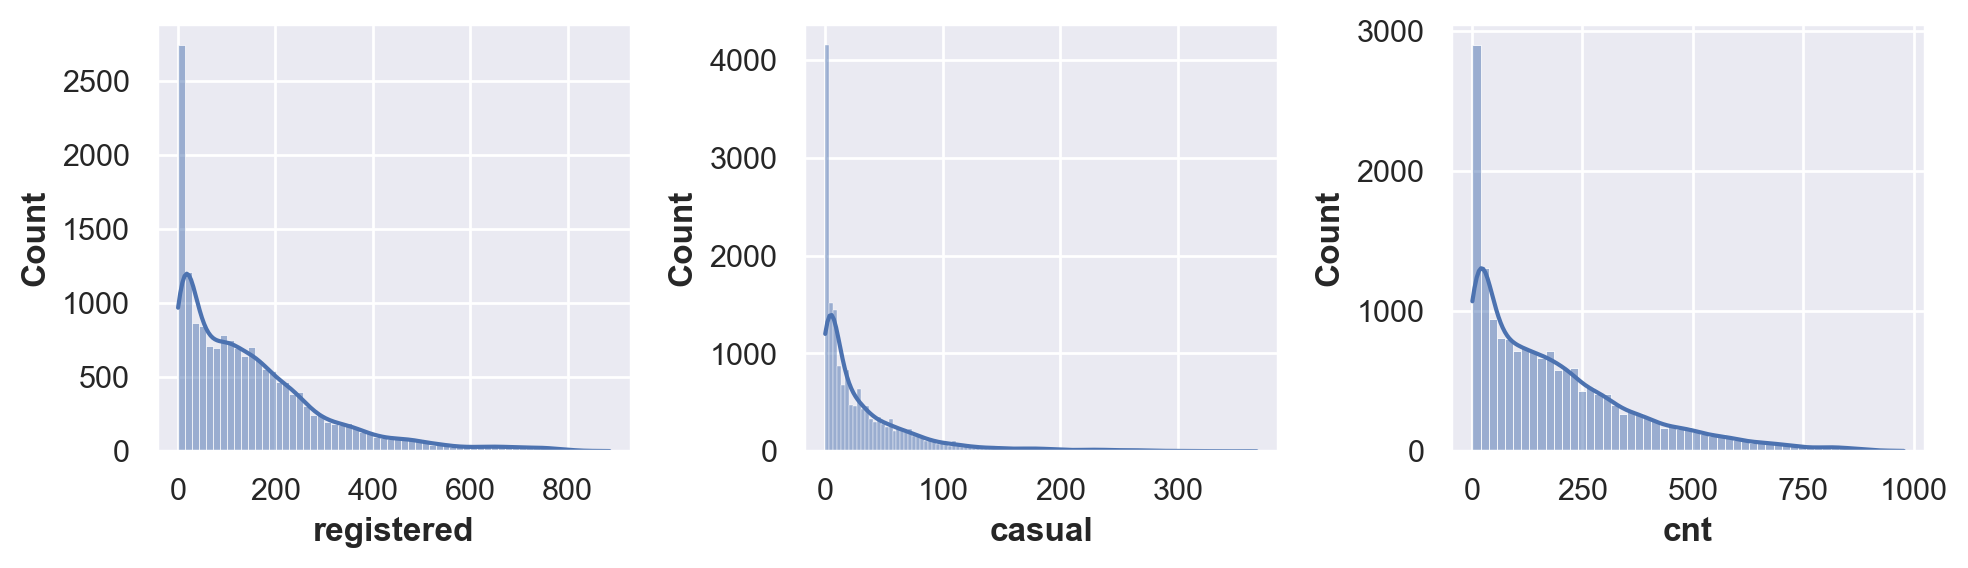

In [45]:
# Visualize the distribution of the targets
targets=['registered','casual','cnt']
fig=plt.figure(figsize=(10,3))
for idx, ele in enumerate(targets):
    ax=plt.subplot(1, 3, (idx+1))
    sns.histplot(df, x=ele, ax=ax, kde=True)

Insights:
- Target variable 'cnt' follows a nearly poisson distribution, std=181, mean = 189, see df.describe table. 
(Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time. The mean and standard deviation of poisson distribution are equal.)

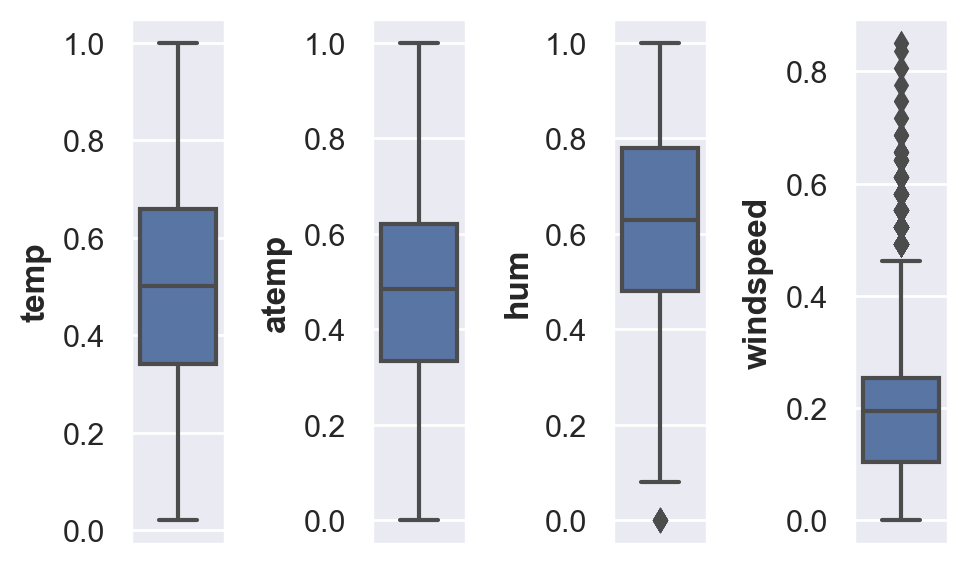

In [46]:
num_features=['temp','atemp','hum','windspeed']
fig=plt.figure(figsize=(5,3))
for idx, ele in enumerate(num_features):
    sns.boxplot(df, y=ele, ax=plt.subplot(1,4,(idx+1)))

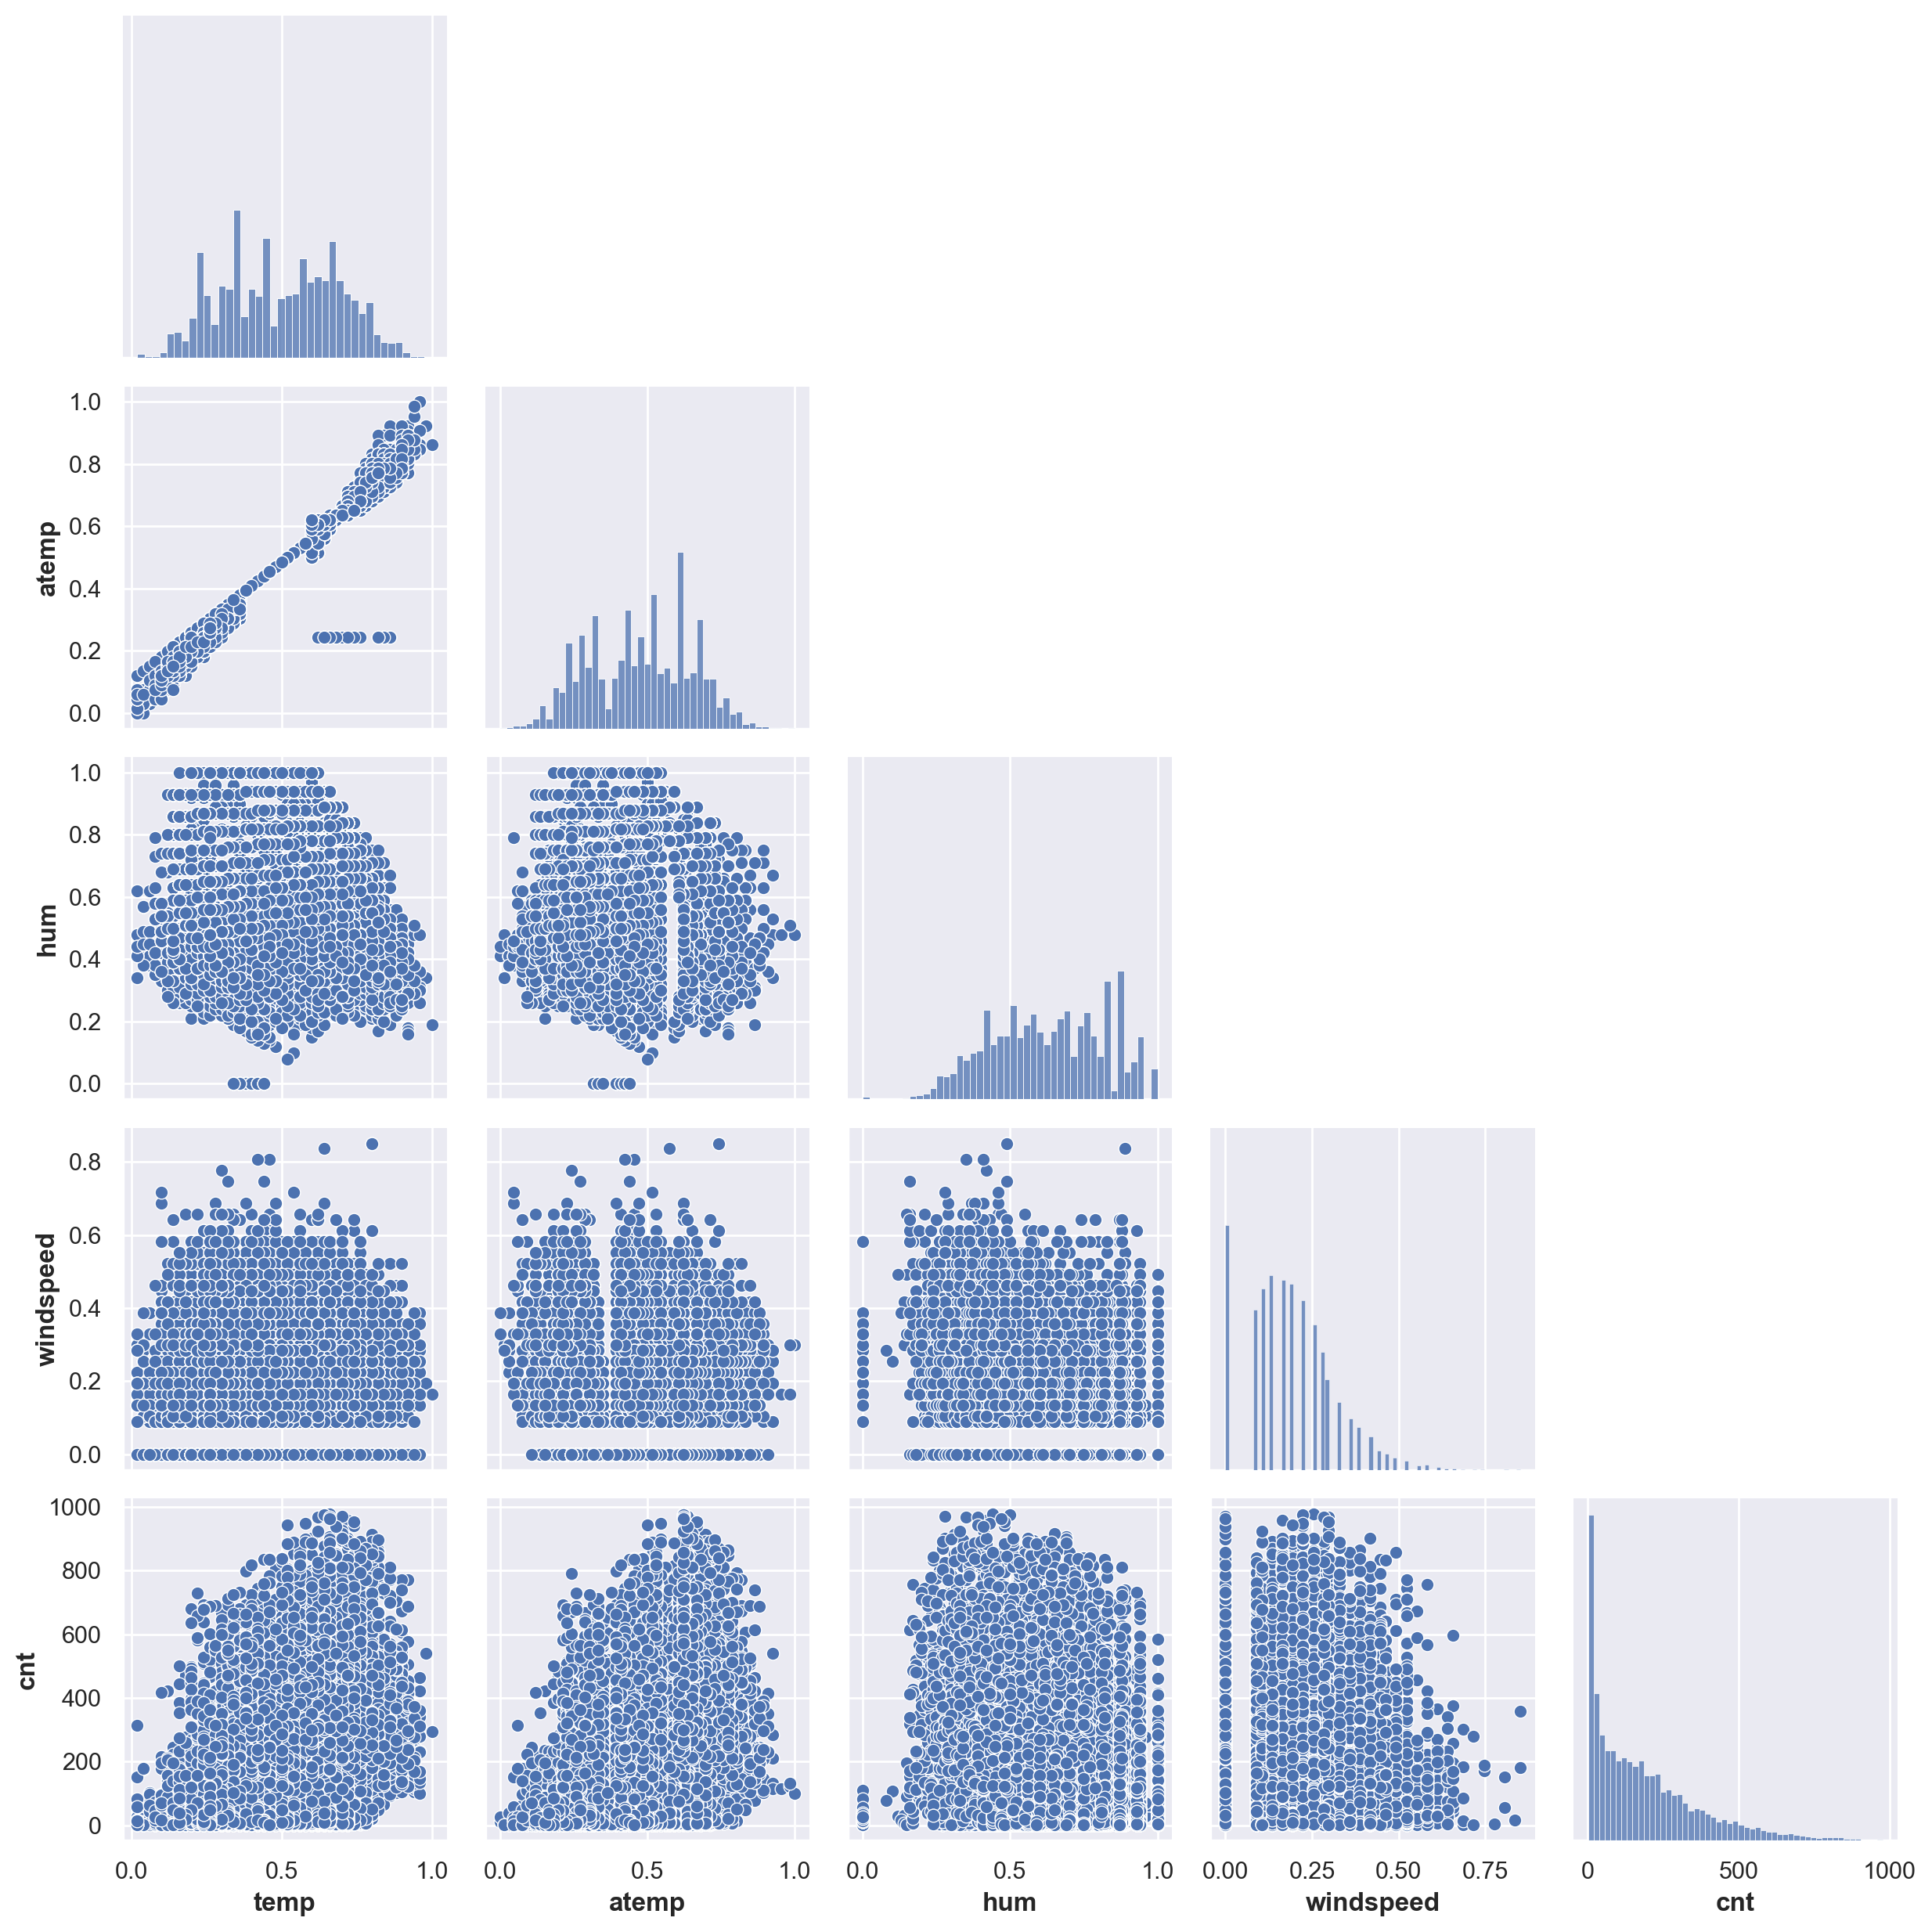

In [ ]:
sns.pairplot(df[num_features], corner=True)

Insights:
- 'windspeed', 'hum'and 'cnt' have some outliers. (dive deeper later on if they have impacts for analysis)
- 'atemp' and 'temp' are highly correlate. One of them can be removed.
- Seems that 'temp' and 'hum' have linear relation with target 'cnt'.

## IV.2 Explore categorical variables 

It is a time series dataset. We will explore the seasonality through several different techniques.
(Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.)

In [ ]:
cat_features=['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
for i in cat_features:
    print(df[i].value_counts(), '\n')

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64 

1    8734
0    8645
Name: yr, dtype: int64 

5     1488
7     1488
12    1483
8     1475
3     1473
10    1451
6     1440
4     1437
9     1437
11    1437
1     1429
2     1341
Name: mnth, dtype: int64 

17    730
16    730
13    729
15    729
14    729
12    728
22    728
21    728
20    728
19    728
18    728
23    728
11    727
10    727
9     727
8     727
7     727
0     726
6     725
1     724
5     717
2     715
4     697
3     697
Name: hr, dtype: int64 

0    16879
1      500
Name: holiday, dtype: int64 

6    2512
0    2502
5    2487
1    2479
3    2475
4    2471
2    2453
Name: weekday, dtype: int64 

1    11865
0     5514
Name: workingday, dtype: int64 

1    11413
2     4544
3     1419
4        3
Name: weathersit, dtype: int64 



Insights: 
- 'yr' have 2 values. Dataset contains 2 years of data. 1 observation/hour.
- 'weathersit' has only 3 observations for level 4.
- 'holiday' is a biased column. There is only 500 observations. Anomalies analysis need  to be considered during modeling. (imbalanced dataset: classes are not represented equally or in other words one class has much more instances than the others, causing several problems such as the model cannot capture the minority class.)

## IV.3 Relationship between variables

### IV.3.1 Daily rental habit of users

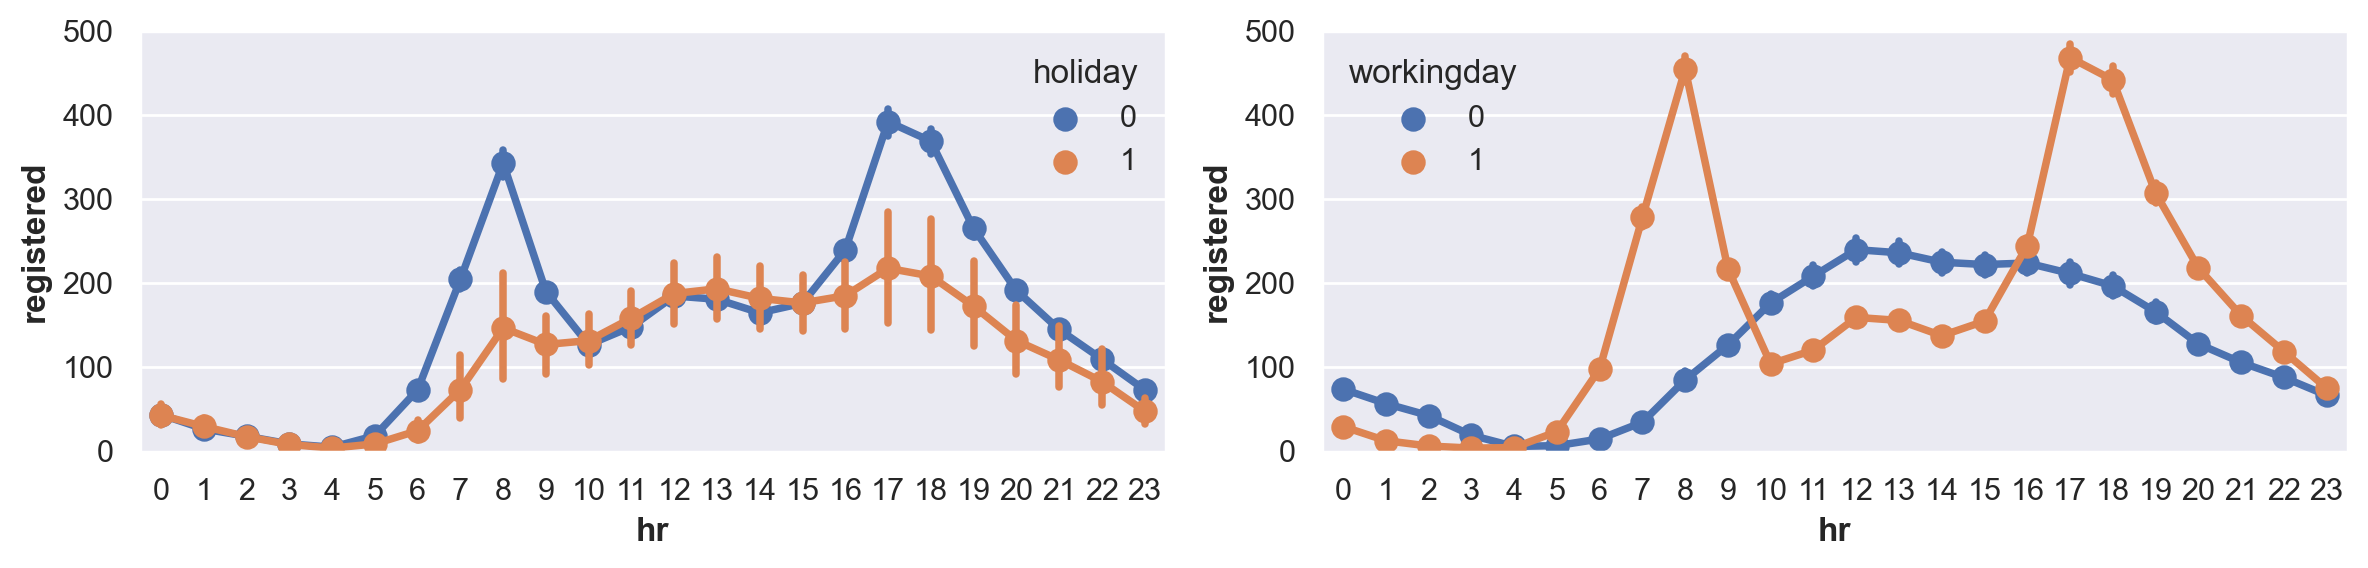

In [ ]:
fig=plt.figure(figsize=(12,3))
for idx, ele in enumerate(['holiday','workingday']):
    ax=plt.subplot(1,2,(idx+1))
    sns.pointplot(df, x='hr', y='registered', hue = ele, ax=ax)
    ax.set(ylim=[0,500])

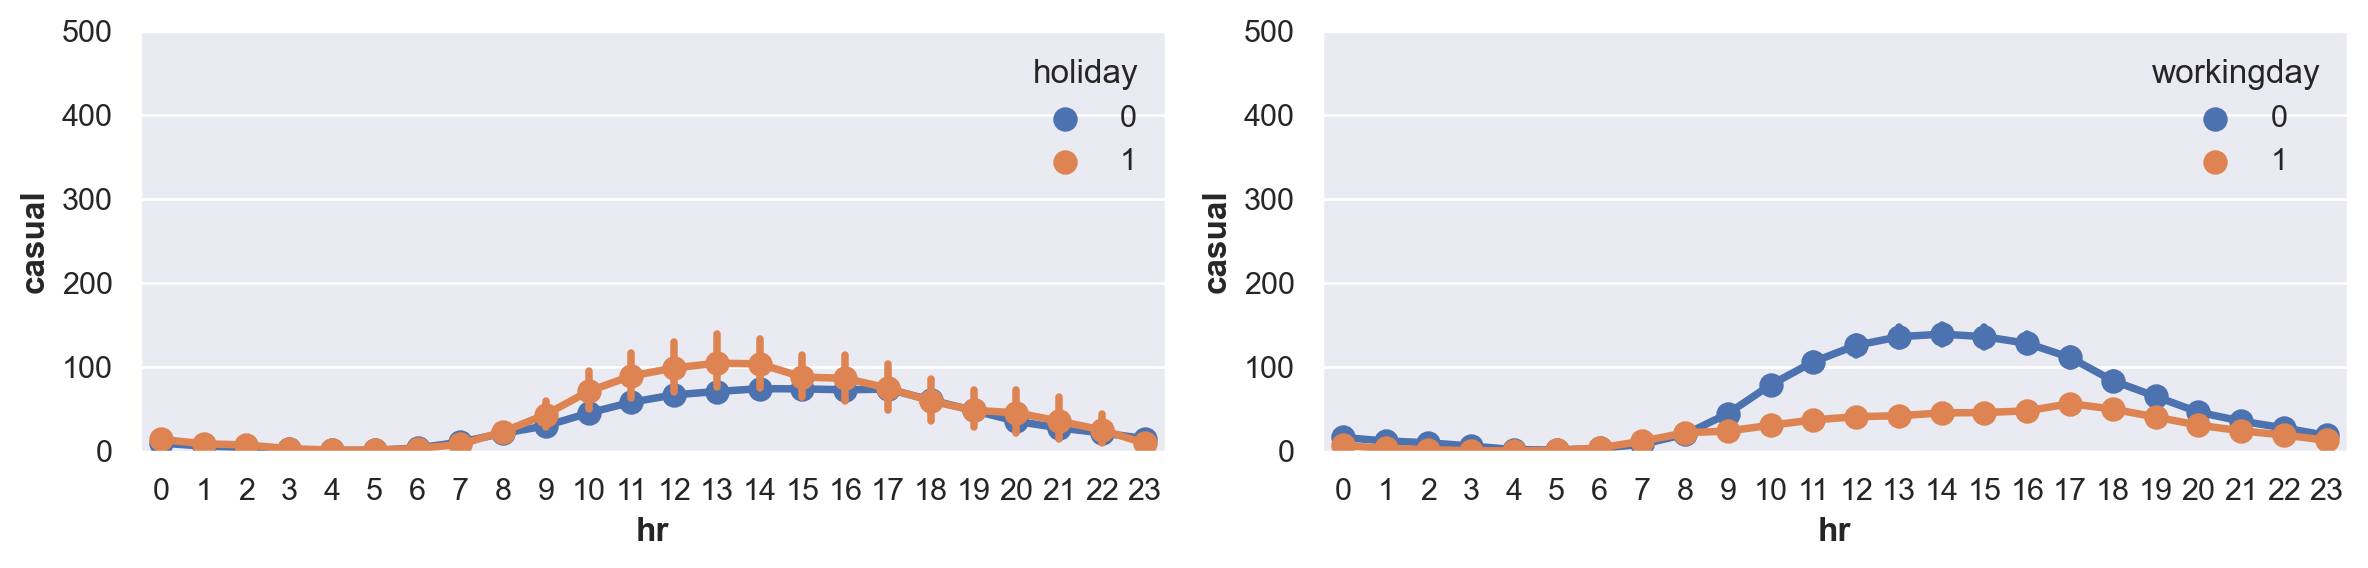

In [ ]:
fig=plt.figure(figsize=(12,3))
for idx, ele in enumerate(['holiday','workingday']):
    ax=plt.subplot(1,2,(idx+1))
    sns.pointplot(df, x='hr', y='casual', hue = ele, ax=ax)
    ax.set(ylim=[0,500])

Insights: 
- During working days, registered users take bikes especially for going to work. 2 picks around 500 are found between 7h-9h am (time go to work) and 4h-8h pm (time back to home) on working days. Casual users do not have this pattern. The lowest num for registered user is around 150. Causal users take rarely bikes on working day with max number around 50. 
- At the weekend, both of registered and casual users take bikes during the day between 8 am and 8 pm, again registered users are 2 times more than casual users (max 250 vs 150).
- There is slightly difference between holiday and weekend. For both of 2 types of users, count at weekends is more than that on holidays (max ~250 vs ~200, ~130 vs ~80)

### IV.3.2 Long-term trend and seasonality analysis

In [ ]:
# Change the date dtype from object to datetime
df['dteday'] = pd.to_datetime(df['dteday'])
df['dteday'].dtype

dtype('<M8[ns]')

In [ ]:
bikers_day=df.groupby('dteday')['cnt'].sum()
bikers_day.head()

dteday
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
Name: cnt, dtype: int64

In [ ]:
bikers_day.shape

(731,)

In [ ]:
# change date dtype from datetime to periodic type
bikers_day.index.to_period()

PeriodIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
             '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
             '2011-01-09', '2011-01-10',
             ...
             '2012-12-22', '2012-12-23', '2012-12-24', '2012-12-25',
             '2012-12-26', '2012-12-27', '2012-12-28', '2012-12-29',
             '2012-12-30', '2012-12-31'],
            dtype='period[D]', name='dteday', length=731)

In [ ]:
# transform series to dataframe, since rolling function accept only df
bikers_day=bikers_day.to_frame()

In [ ]:
bikers_day.rename(columns={'cnt':'cnt/day'}, inplace=True)

In [ ]:
bikers_day.head()

cnt/day
dteday             
2011-01-01      985
2011-01-02      801
2011-01-03     1349
2011-01-04     1562
2011-01-05     1600

In [ ]:
bikers_day.describe().T

count         mean          std   min     25%     50%     75%     max
cnt/day  731.0  4504.348837  1937.211452  22.0  3152.0  4548.0  5956.0  8714.0

<Axes: >

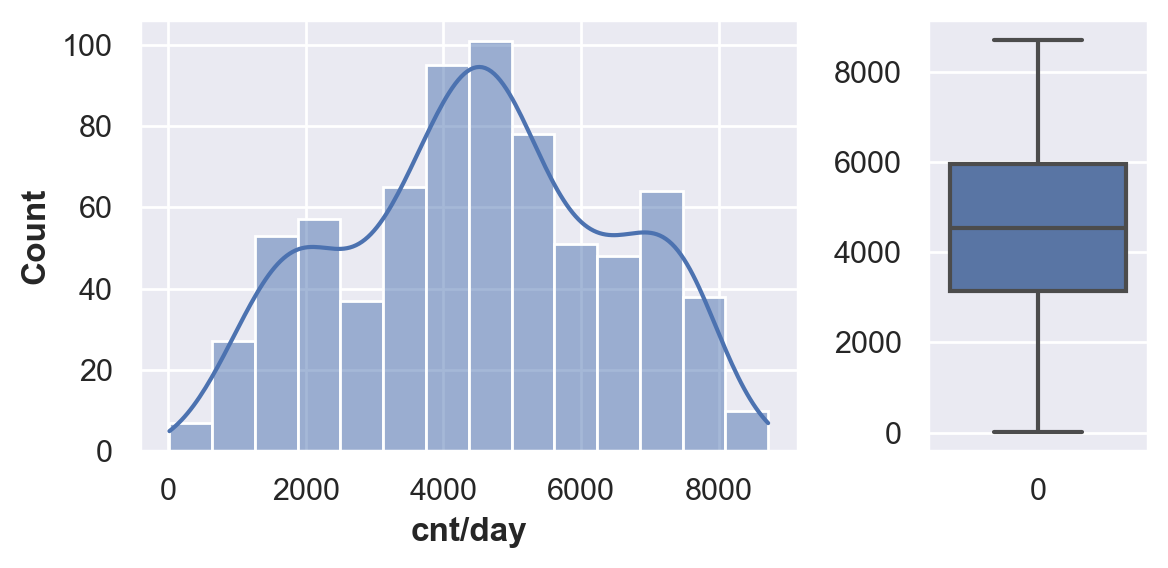

In [ ]:
fig=plt.figure(figsize=(6,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax0=plt.subplot(gs[0])
sns.histplot(bikers_day['cnt/day'], ax=ax0, kde=True)
ax1=plt.subplot(gs[1])
sns.boxplot(bikers_day['cnt/day'], ax=ax1)

Insights: 
- From the histogram above, it seems that the number of total rented bikes per day follow a nearly normal distribution, with mean ~ median. 
- No outliers. 

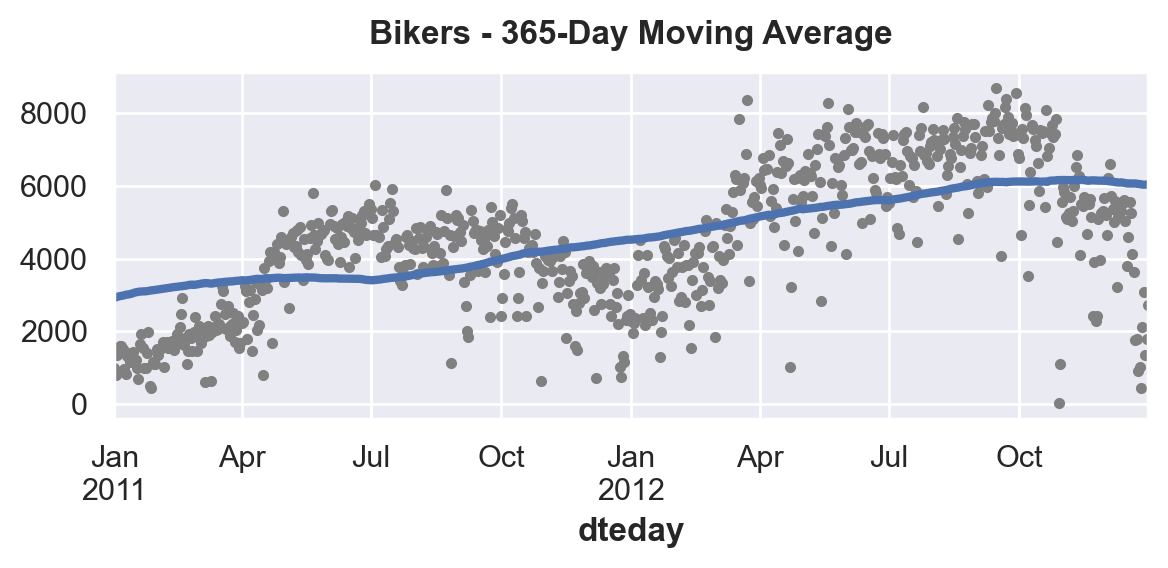

In [ ]:
# 365-day window, puts the average at the center of the window, choose about half the window size,
# compute the mean (could also do median, std, min, max, ...)
moving_average = bikers_day.rolling(window=365,center=True,min_periods=183).mean()
fig, ax=plt.subplots(figsize=(6,3))
ax = bikers_day['cnt/day'].plot(style='.', color='0.5')
moving_average.plot(ax=ax,linewidth=3,title='Bikers-365-Day Moving Average',legend=False,);

In [ ]:
bikers_day['year']=bikers_day.index.year
bikers_day['dayofyear']=bikers_day.index.dayofyear
bikers_day['week']=bikers_day.index.week
bikers_day['dayofweek']=bikers_day.index.dayofweek
bikers_day.head()

cnt/day  year  dayofyear  week  dayofweek
dteday                                               
2011-01-01      985  2011          1    52          5
2011-01-02      801  2011          2    52          6
2011-01-03     1349  2011          3     1          0
2011-01-04     1562  2011          4     1          1
2011-01-05     1600  2011          5     1          2

Text(0.5, 1.0, 'Seasonal Plot dayofyear/year')

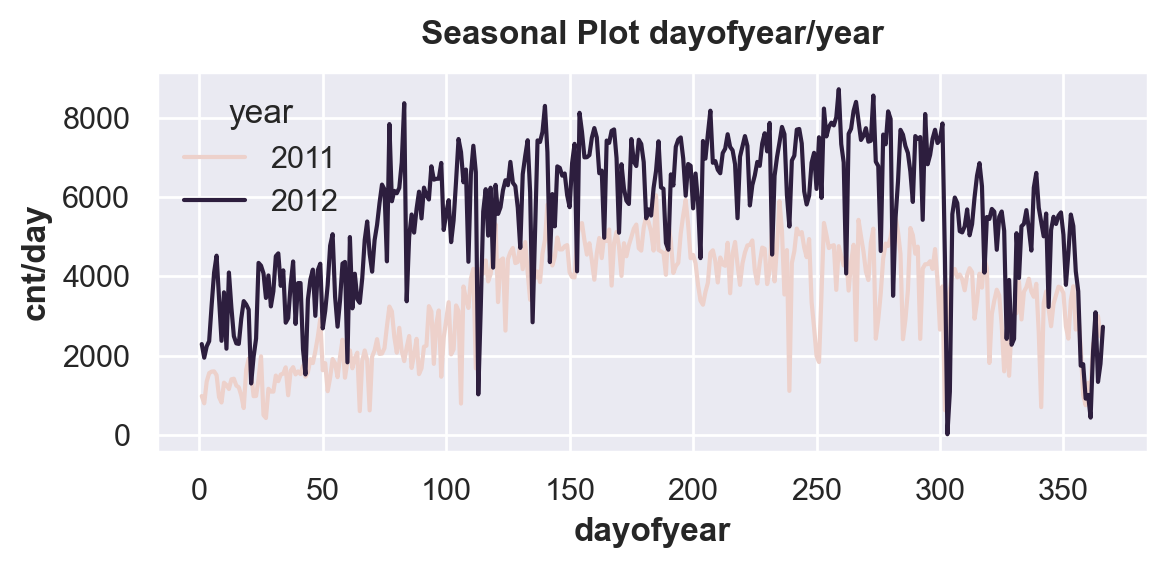

In [ ]:
fig,ax= plt.subplots(figsize=(6, 3))
sns.lineplot(data=bikers_day, x= 'dayofyear', y='cnt/day', hue='year', ax=ax)
palette = sns.color_palette('husl', n_colors=bikers_day['year'].nunique())
ax.set_title('Seasonal Plot dayofyear/year')

Text(0.5, 1.0, 'Seasonal Plot dayofweek/week')

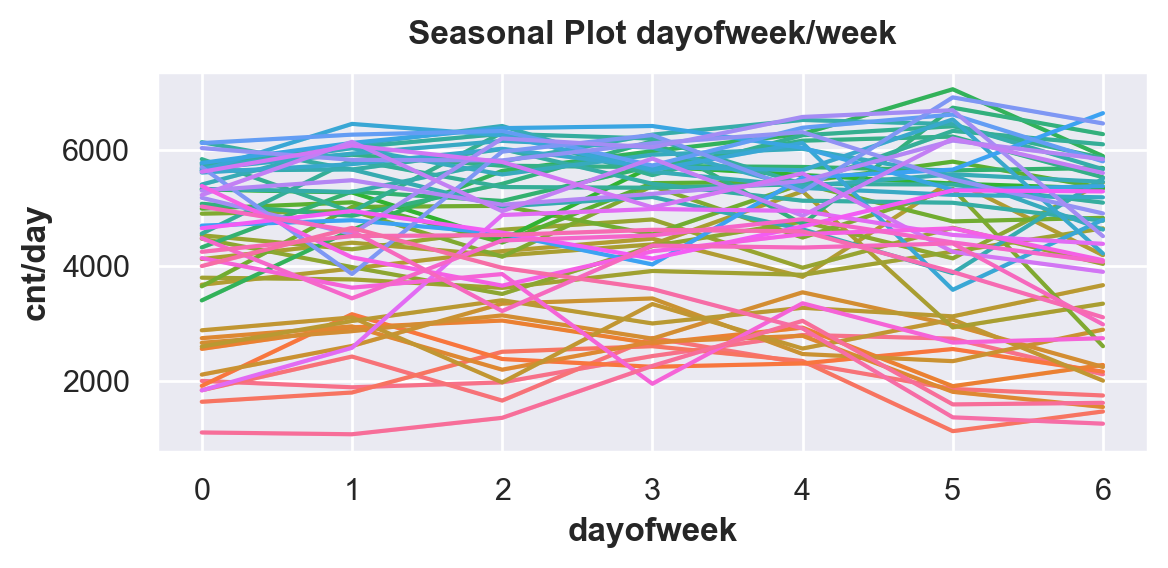

In [ ]:
fig,ax= plt.subplots(figsize=(6, 3))
palette = sns.color_palette('husl', n_colors=bikers_day['week'].nunique(),)
sns.lineplot(data=bikers_day, x= 'dayofweek', y='cnt/day', hue='week', ax=ax, palette=palette, legend=False, ci=False)
ax.set_title('Seasonal Plot dayofweek/week')

Insights:
- A yearly seasonality is clearly displayed, without seasonal, monthly or weekly seasonality.
- A moving average plot illustrating a linear trend. Each point on the curve (blue) is the average of the points (grey) within a window of size 365. The slight increasing trend in the moving mean (from 3000 to 6000) is observed during these 2 years, indicating the effect of a market expansion as more people (doubled) become sharing bikers year by year. This hints that the variable yr could be important for the prediction task.
- The periodogram agrees with the seasonal plots above: a strong annual seasonality.

Text(0.5, 1.0, 'Periodogram')

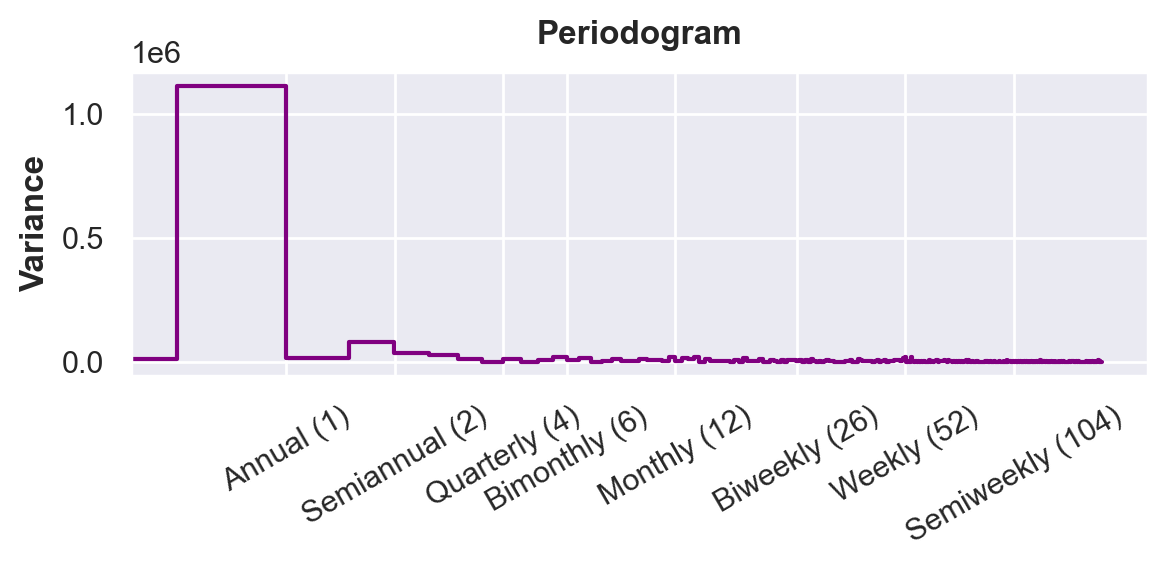

In [ ]:
fs = pd.Timedelta('365D') / pd.Timedelta('1D')
freqencies, spectrum = periodogram (bikers_day['cnt/day'], fs=fs, detrend='linear', window='boxcar', scaling='spectrum',)
fig, ax = plt.subplots(figsize=(6,3))
ax.step(freqencies, spectrum, color='purple')
ax.set_xscale("log")
ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
ax.set_xticklabels(['Annual (1)','Semiannual (2)','Quarterly (4)','Bimonthly (6)','Monthly (12)',
                    'Biweekly (26)','Weekly (52)','Semiweekly (104)',],rotation=30)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.set_ylabel("Variance")
ax.set_title("Periodogram")

### IV.3.3 Influence of individual predictor

Next, let's visualize the relationship between the response variable and each explanatory variable. We selected some plots with obvious patterns as shown below. 

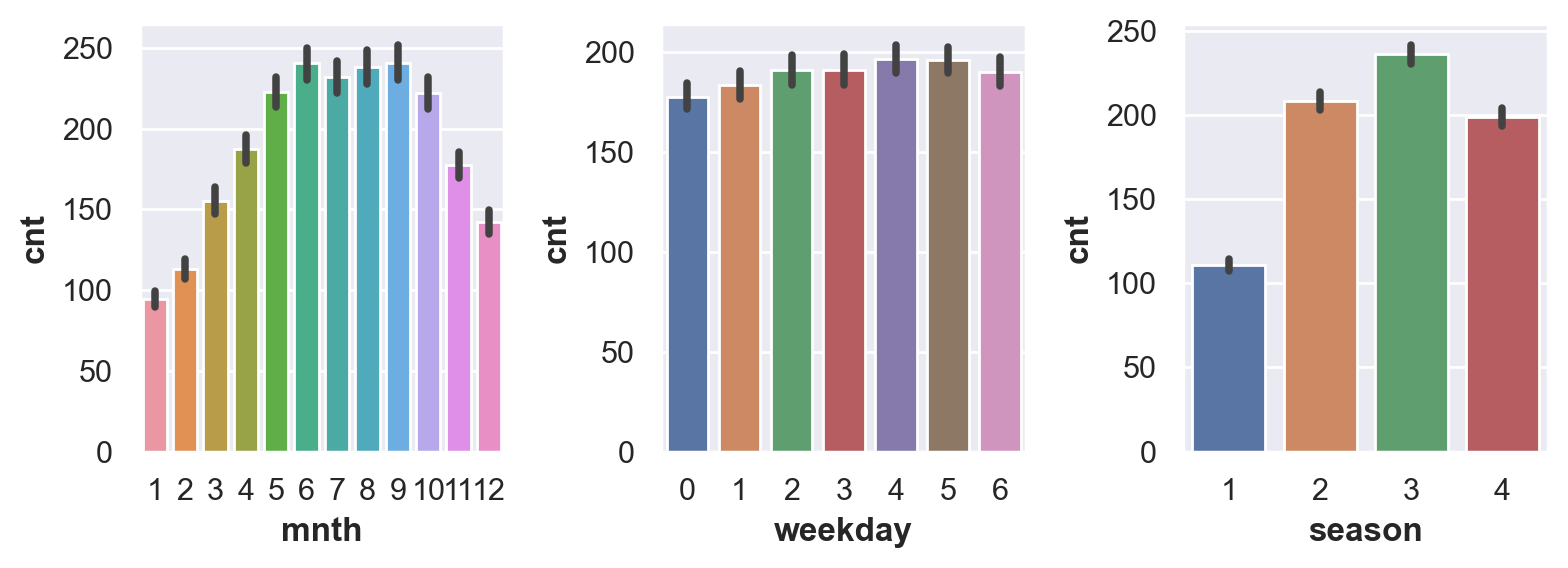

In [ ]:
fig=plt.figure(figsize=(8,3))
for idx, ele in enumerate(['mnth','weekday','season']):
    sns.barplot(df, x=ele, y='cnt', ax=plt.subplot(1,3,(idx+1)))

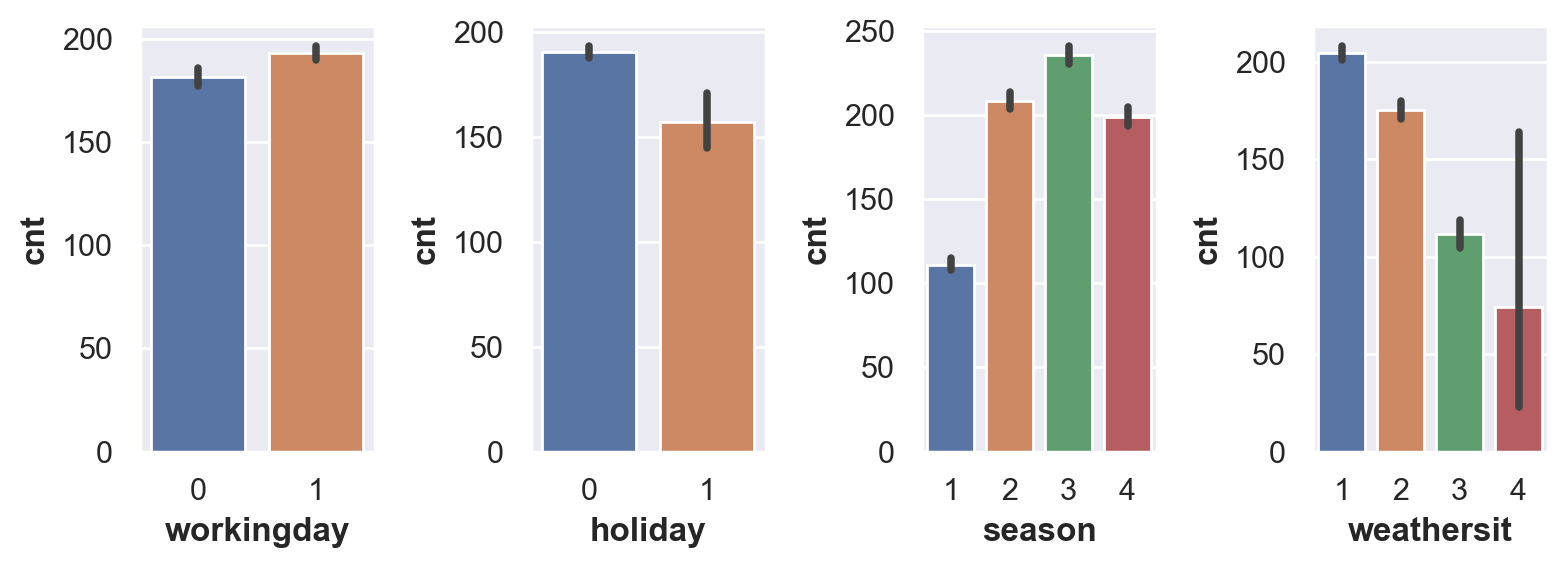

In [ ]:
fig=plt.figure(figsize=(8,3))
for idx, ele in enumerate(['workingday','holiday','season','weathersit']):
    sns.barplot(df, x=ele, y='cnt', ax=plt.subplot(1,4,(idx+1)))

Insights:
- Month and season plots show that the numbers of bike rentals are the highest during summer and fall, followed closely by winter. Spring is significantly lower.
- Workingday, weekday, and holiday plots show the number of bike rentals on non-holiday and working days is higher than holiday and weekend.
- There is a clearly decreasing trend of bike rentals when weather conditions grow worse. 

### IV.3.4 Correlation between variables

In [ ]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [ ]:
# Put useless columns in the index
df=df.set_index(['instant', 'dteday', 'casual','registered', 'atemp'],append=True)

In [ ]:
# change season to categorical feature
df[['season', 'mnth','weekday', 'hr', 'weathersit']] = df[['season', 'mnth','weekday', 'hr', 'weathersit']].astype('category')
df['season'].dtype

CategoricalDtype(categories=[1, 2, 3, 4], ordered=False)

In [ ]:
# Creating dummies 
df1=pd.get_dummies(df, drop_first=True)
df1.head()

yr  holiday  workingday  temp  \
  instant dteday     casual registered atemp                                   
0 1       2011-01-01 3      13         0.2879   0        0           0  0.24   
1 2       2011-01-01 8      32         0.2727   0        0           0  0.22   
2 3       2011-01-01 5      27         0.2727   0        0           0  0.22   
3 4       2011-01-01 3      10         0.2879   0        0           0  0.24   
4 5       2011-01-01 0      1          0.2879   0        0           0  0.24   

                                                hum  windspeed  cnt  season_2  \
  instant dteday     casual registered atemp                                    
0 1       2011-01-01 3      13         0.2879  0.81        0.0   16         0   
1 2       2011-01-01 8      32         0.2727  0.80        0.0   40         0   
2 3       2011-01-01 5      27         0.2727  0.80        0.0   32         0   
3 4       2011-01-01 3      10         0.2879  0.75        0.0   13         0   
4 5       2011-01-01 0      1          0.2879  0.75        0.0    1         0   

                                               season_3  season_4  ...  hr_23  \
  instant dteday     casual registered atemp                       ...          
0 1       2011-01-01 3      13         0.2879         0         0  ...      0   
1 2       2011-01-01 8      32         0.2727         0         0  ...      0   
2 3       2011-01-01 5      27         0.2727         0         0  ...      0   
3 4       2011-01-01 3      10         0.2879         0         0  ...      0   
4 5       2011-01-01 0      1          0.2879         0         0  ...      0   

                                               weekday_1  weekday_2  \
  instant dteday     casual registered atemp                          
0 1       2011-01-01 3      13         0.2879          0          0   
1 2       2011-01-01 8      32         0.2727          0          0   
2 3       2011-01-01 5      27         0.2727          0          0   
3 4       2011-01-01 3      10         0.2879          0          0   
4 5       2011-01-01 0      1          0.2879          0          0   

                                               weekday_3  weekday_4  \
  instant dteday     casual registered atemp                          
0 1       2011-01-01 3      13         0.2879          0          0   
1 2       2011-01-01 8      32         0.2727          0          0   
2 3       2011-01-01 5      27         0.2727          0          0   
3 4       2011-01-01 3      10         0.2879          0          0   
4 5       2011-01-01 0      1          0.2879          0          0   

                                               weekday_5  weekday_6  \
  instant dteday     casual registered atemp                          
0 1       2011-01-01 3      13         0.2879          0          1   
1 2       2011-01-01 8      32         0.2727          0          1   
2 3       2011-01-01 5      27         0.2727          0          1   
3 4       2011-01-01 3      10         0.2879          0          1   
4 5       2011-01-01 0      1          0.2879          0          1   

                                               weathersit_2  weathersit_3  \
  instant dteday     casual registered atemp                                
0 1       2011-01-01 3      13         0.2879             0             0   
1 2       2011-01-01 8      32         0.2727             0             0   
2 3       2011-01-01 5      27         0.2727             0             0   
3 4       2011-01-01 3      10         0.2879             0             0   
4 5       2011-01-01 0      1          0.2879             0             0   

                                               weathersit_4  
  instant dteday     casual registered atemp                 
0 1       2011-01-01 3      13         0.2879             0  
1 2       2011-01-01 8      32         0.2727             0  
2 3       2011-01-01 5      27         0.2727             0  
3 4   

In [ ]:
df1.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7',
       'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15',
       'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

In [ ]:
X_vif= df1.drop('cnt', axis=1)

In [ ]:
# VIF variables set 
X_vif=add_constant(X_vif)
  
# Calculating VIF for each feature and store the values in vif_df dataframe
vif_df = pd.DataFrame() 
vif_df['Feature'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])] 
vif_df['VIF'] = round(vif_df['VIF'], 2)
vif_df = vif_df.sort_values(by = "VIF", ascending = False)
vif_df.head(15)

Feature    VIF
2      holiday    inf
3   workingday    inf
49   weekday_5    inf
48   weekday_4    inf
45   weekday_1    inf
46   weekday_2    inf
47   weekday_3    inf
0        const  73.88
4         temp  54.22
5        atemp  46.49
9     season_3  10.64
16      mnth_7   8.58
17      mnth_8   8.09
8     season_2   7.50
10    season_4   7.37

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

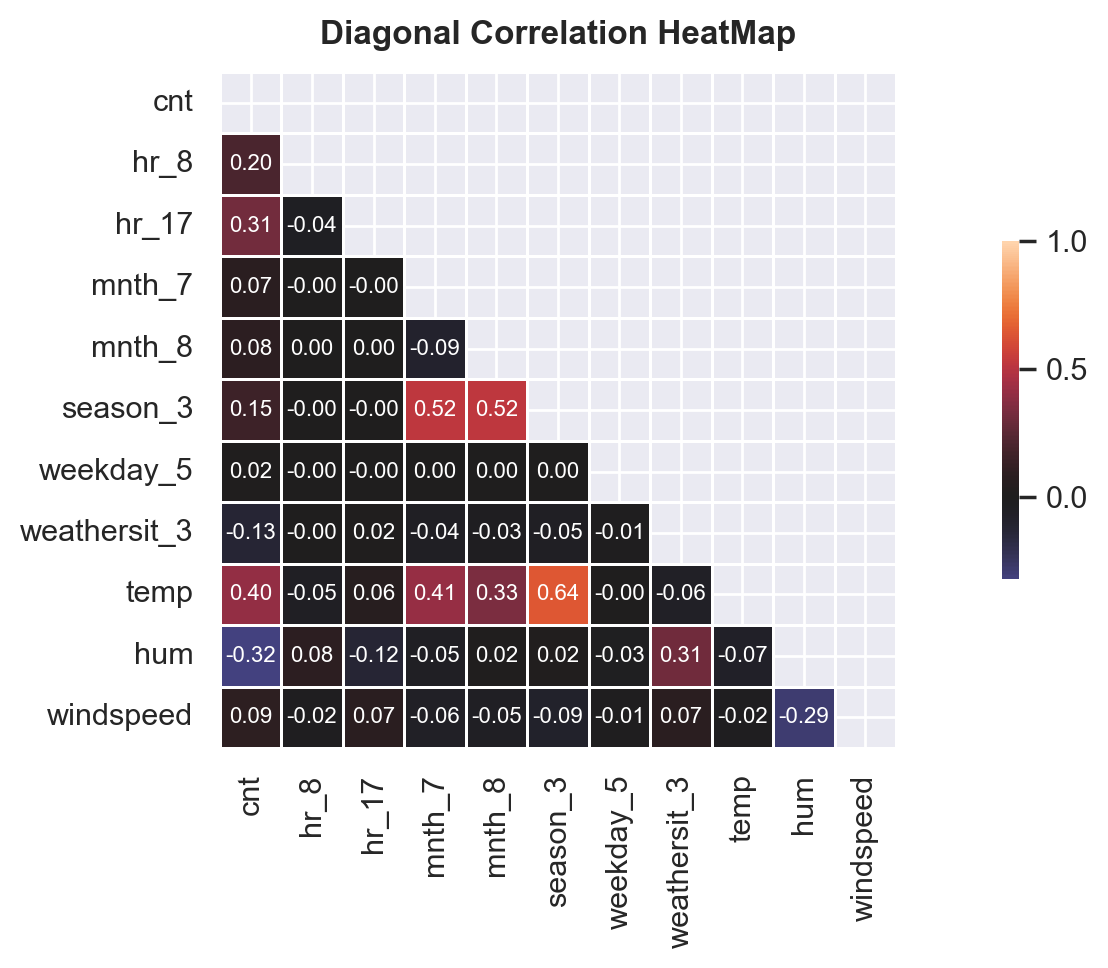

In [ ]:
#  Chose some features to visualize correlation by heatmap 
fig, ax = plt.subplots()
X_to_corr=['cnt', 'hr_8', 'hr_17','mnth_7','mnth_8','season_3', 'weekday_5','weathersit_3','temp' ,'hum', 'windspeed']
corr = df1[X_to_corr].corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask,vmax=1, center=0, annot=True, fmt='.2f', square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={'size':8})
plt.title("Diagonal Correlation HeatMap")

Insights:
-  Through VIF and correlation heatmap, we see briefly season has intermediate positive linear correlation with both of temp and month. 
- 'holiday' 'workingday' 'weekday' are highly correlated.
- temp, hr, hum have linear correlation with target variable cnt.

# V Machine learning modeling

- Any redundant variable is dropped, as we will use regularization in our models. Let model do the selection to see how model react on them, thus can avoid any human selection bias.
- We will train 4 models: a linear lasso model, a polynomial degree2 lasso model, a random forest model, a gradient boosting tree model.
- The linear Lasso model and polynomial lasso model are used as benchmark, since they are basic simple models.
- Tree based models are very intuitive, easy to explain and powerful. Moreover, tree_based models work well with imbalanced data. However, when dealing with time series, the time-dependent trend/seasonality is lost. Our data set displays clear yearly trend, therefore RF may not perform very well. GBR model performs better on time series dataset than RF. 
- Our scoring metric is the mean-squared-error (mse).
- After separating X and y, we do a train test split without shuffle since we have a time series dataset.

In [ ]:
y=df1.pop('cnt')

In [ ]:
X=df1
X.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weathersit_2', 'weathersit_3', 'weathersit_4'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

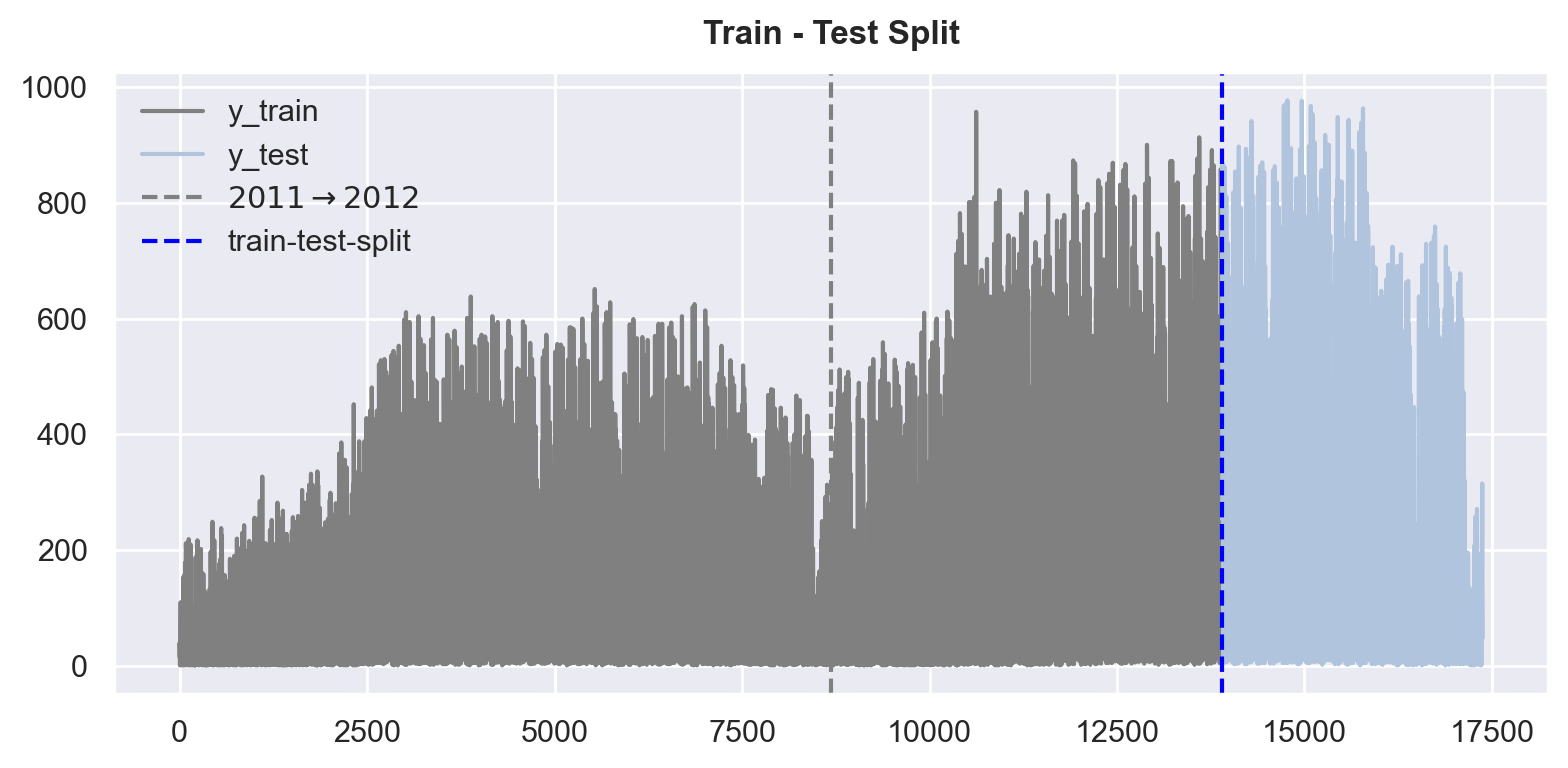

In [ ]:
# Visualize the split
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot(x = y_train.index, y = y_train.values, color='gray',label='y_train',ax=ax)
sns.lineplot(x=y_test.index,y=y_test.values, color='lightblue', label='y_test',ax=ax)
ax.axvline(x=8689, color='gray', linestyle='--', label=r'$2011 \rightarrow 2012$')
ax.axvline(x=y_train.shape[0], color='blue', linestyle='--', label='train-test-split')
ax.legend(loc='upper left')
ax.set(title='Train - Test Split');

## V.1 Linear lasso model

In [ ]:
# Scale X
scaler=StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
X_train_scaled=pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled=pd.DataFrame(X_test_scaled,index=X_test.index, columns=X_train.columns)

In [ ]:
X_train_scaled.shape, y_train.shape, X_test_scaled.shape,  y_test.shape

((13903, 52), (13903,), (3476, 52), (3476,))

In [ ]:
# define lambdas
n = X_train_scaled.shape[0]
lambda_max = np.fabs(X_train_scaled.T.dot(y_train - y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100))* lambda_max}

In [ ]:
lasso=ElasticNet(l1_ratio=1)
cv = TimeSeriesSplit(n_splits=5, test_size=(7 * 2), gap=0)
grid=GridSearchCV(lasso, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')
grid.fit(X=X_train_scaled, y=y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=14),
             estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': array([71.93391704, 68.66440949, 65.54350611, 62.5644526 , 59.72080167,
       57.00639907, 54.41537025, 51.94210769, 49.58125873, 47.327714  ,
       45.17659636, 43.12325033, 41.16323205, 39.29229962, 37.50640396,
       35.80168002, 34.17443841, 32.621...
        2.77199406,  2.64600265,  2.52573775,  2.41093907,  2.30135817,
        2.19675789,  2.09691185,  2.00160397,  1.91062798,  1.82378699,
        1.74089306,  1.66176678,  1.58623692,  1.51414   ,  1.44532   ,
        1.37962798,  1.31692176,  1.25706563,  1.19993006,  1.14539138,
        1.09333158,  1.04363797,  0.99620301,  0.95092405,  0.90770308,
        0.86644658,  0.82706524,  0.78947385,  0.75359105,  0.71933917])},
             scoring='neg_mean_squared_error')

In [ ]:
print(f'best lambda of linear lasso model: {grid.best_params_}')

best lambda of linear lasso model: {'alpha': 0.7193391704290343}


In [ ]:
# define score function to calculate score
def score (model, X, y):
    scorer_mse = get_scorer('neg_mean_squared_error')
    mse=scorer_mse(model, X, y)
    scorer_r2 = get_scorer('r2') 
    r2=scorer_r2(model, X, y)
    return {'mse':mse, 'r2':r2}
    

In [ ]:
lasso_train_score= score (grid.best_estimator_, X_train_scaled, y_train)
lasso_test_score= score (grid.best_estimator_, X_test_scaled, y_test)
lasso_train_score, lasso_test_score

({'mse': -8761.668050700227, 'r2': 0.6856474246127253},
 {'mse': -18480.034313837743, 'r2': 0.6198584020798443})

## V.2 Degree2 polynomial lasso model

In [ ]:
poly = PolynomialFeatures(degree = 2, include_bias = False, interaction_only = True)
poly.fit(X_train)
X_train_poly=poly.transform(X_train) 
poly_scaler=StandardScaler().fit(X_train_poly)
X_train_poly_scaled=poly_scaler.transform(X_train_poly)

In [ ]:
n_poly = X_train_poly_scaled.shape[0]
lambda_max_poly=np.fabs(X_train_poly_scaled.T.dot(y_train-y_train.mean())).max()/n_poly
param_grid_poly={'alpha': np.exp(np.linspace(0, np.log(0.01), 100))* lambda_max}

In [ ]:
grid_poly=GridSearchCV(lasso, param_grid=param_grid_poly, cv=cv, scoring='neg_mean_squared_error')
grid_poly.fit(X=X_train_poly_scaled, y=y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=14),
             estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': array([71.93391704, 68.66440949, 65.54350611, 62.5644526 , 59.72080167,
       57.00639907, 54.41537025, 51.94210769, 49.58125873, 47.327714  ,
       45.17659636, 43.12325033, 41.16323205, 39.29229962, 37.50640396,
       35.80168002, 34.17443841, 32.621...
        2.77199406,  2.64600265,  2.52573775,  2.41093907,  2.30135817,
        2.19675789,  2.09691185,  2.00160397,  1.91062798,  1.82378699,
        1.74089306,  1.66176678,  1.58623692,  1.51414   ,  1.44532   ,
        1.37962798,  1.31692176,  1.25706563,  1.19993006,  1.14539138,
        1.09333158,  1.04363797,  0.99620301,  0.95092405,  0.90770308,
        0.86644658,  0.82706524,  0.78947385,  0.75359105,  0.71933917])},
             scoring='neg_mean_squared_error')

In [ ]:
X_test_poly=poly.transform(X_test) 
X_test_poly_scaled=poly_scaler.transform(X_test_poly)

In [ ]:
poly_train_score=score (grid_poly.best_estimator_, X_train_poly_scaled, y_train)
poly_test_score= score (grid_poly.best_estimator_, X_test_poly_scaled, y_test)
poly_train_score, poly_test_score

({'mse': -2795.0629444489914, 'r2': 0.8997182694125396},
 {'mse': -7435.79216651654, 'r2': 0.8470428210263012})

## V.3 RandamForest model

In [ ]:
# train a RF using default params i.e estimators=100  n=sqrt  criterion=mse
rf0=RF(oob_score=True, random_state=0, criterion='squared_error')
rf0.fit(X_train, y_train)

RandomForestRegressor(oob_score=True, random_state=0)

In [ ]:
rf0_train_score= score (rf0, X_train, y_train)
rf0_test_score= score (rf0, X_test, y_test)
rf0_train_score,rf0_test_score

({'mse': -325.891253422952, 'r2': 0.9883076197115794},
 {'mse': -8252.27828330321, 'r2': 0.8302473794246319})

In [ ]:
# grid search the best n_estimators
param_estimator = {'n_estimators':range(1,101,10)}
grid_estimator= GridSearchCV(estimator=RF(oob_score=True, random_state=0, criterion='squared_error'),
                             param_grid=param_estimator,cv=cv)
grid_estimator.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=14),
             estimator=RandomForestRegressor(oob_score=True, random_state=0),
             param_grid={'n_estimators': range(1, 101, 10)})

In [ ]:
grid_estimator.best_params_, grid_estimator.best_score_

({'n_estimators': 91}, 0.8801726993130211)

In [ ]:
rf_91trees_train_score=score (grid_estimator.best_estimator_, X_train, y_train)
rf_91trees_test_score=score (grid_estimator.best_estimator_, X_test, y_test)
rf_91trees_train_score, rf_91trees_test_score
# Results are nearly the same as rfO

({'mse': -328.16841469373117, 'r2': 0.9882259193428939},
 {'mse': -8252.806294530896, 'r2': 0.830236518025329})

In [ ]:
# set n_estimators=91, grid search the best max_features. 
# There are 50 features in X, default ~7, so we search 1-11
param_feature = {'max_features':range(1,25,1)}
grid_feature= GridSearchCV(estimator=RF(n_estimators=91, oob_score=True, random_state=0, 
                                        criterion='squared_error'), param_grid=param_feature,cv=cv)
grid_feature.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=14),
             estimator=RandomForestRegressor(n_estimators=91, oob_score=True,
                                             random_state=0),
             param_grid={'max_features': range(1, 25)})

In [ ]:
grid_feature.best_params_, grid_feature.best_score_

({'max_features': 24}, 0.8889741841951515)

In [ ]:
rf_91trees_24features_train_score=score (grid_feature.best_estimator_, X_train, y_train)
rf_91trees_24features_test_score=score (grid_feature.best_estimator_, X_test, y_test)
rf_91trees_24features_train_score, rf_91trees_24features_test_score
# Results are not improved. With RF, the best r2 obtained on test set is 83%.

({'mse': -342.86801348422097, 'r2': 0.9876985247063691},
 {'mse': -8924.540002912296, 'r2': 0.8164186905827833})

In [ ]:
# Train the final RF using the best n_estimators and max_features 
rf_final=RF(oob_score=True, random_state=0, n_estimators=91, max_features=24, criterion='squared_error')
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_features=24, n_estimators=91, oob_score=True,
                      random_state=0)

In [ ]:
rf_final_train_score=score (rf_final, X_train, y_train)
rf_final_test_score=score (rf_final, X_test, y_test)
rf_final_train_score, rf_final_test_score

({'mse': -342.86801348422097, 'r2': 0.9876985247063691},
 {'mse': -8924.540002912296, 'r2': 0.8164186905827833})

In [ ]:
# Train a bagging model
bag = RF(max_features=X_train.shape[1],n_estimators=2000, random_state=0).fit(X_train, y_train)

In [ ]:
bag_train_score=score (bag, X_train, y_train)
bag_test_score=score (bag, X_test, y_test)
bag_train_score, bag_test_score

({'mse': -310.8864310508758, 'r2': 0.9888459652102443},
 {'mse': -8164.54948706144, 'r2': 0.8320519953804576})

Insights:
- Via RandamForest, the mse and r2 for test set are found around 8000 and 0.83. 
- Turning the hyperparameters n_estimators and max_features did not improve the results. 

## V.4 Gradient Boosting Regression model

In [ ]:
# Choose some params and train a basic GBR model and see
gbr0=GBR(random_state=0, learning_rate=0.2, n_estimators=3000, criterion='squared_error')
gbr0.fit(X_train_scaled, y_train)

GradientBoostingRegressor(criterion='squared_error', learning_rate=0.2,
                          n_estimators=3000, random_state=0)

In [ ]:
def gbr_error_curve (model):
    x=np.arange(model.train_score_.shape[0])
    train_errors=model.train_score_

    test_errors=[]
    for i in model.staged_predict(X_test_scaled):
        test_error=np.mean((y_test-i)**2)
        test_errors.append(test_error)
    fig, ax =plt.subplots(figsize=(6,3))
    sns.lineplot(x=x, y=train_errors,label='Training error', ax=ax)
    sns.lineplot(x=x, y=test_errors, label='Test error',ax=ax)
    plt.ylabel('MSE')
    plt.xlabel('Tree')
    plt.title(f'Gradient Boosting Regression')

    test_error=np.mean((y_test-model.predict(X_test_scaled))**2)
    print(f'test_error = {test_error}')
    return ax

test_error = 4803.9136134791


<Axes: title={'center': 'Gradient Boosting Regression'}, xlabel='Tree', ylabel='MSE'>

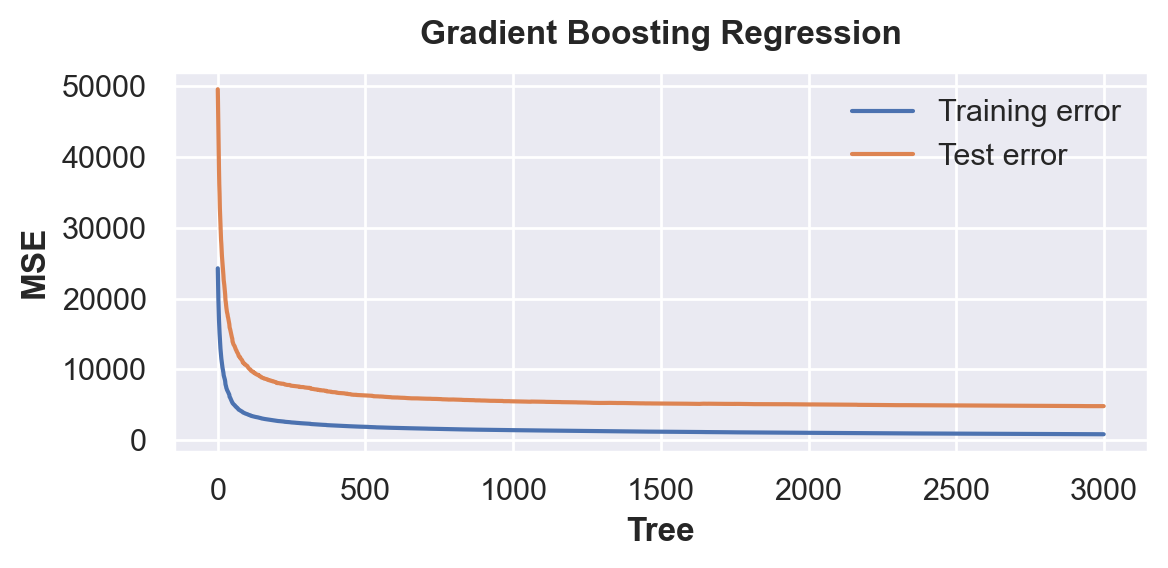

In [ ]:
gbr_error_curve (gbr0)

In [ ]:
gbr_train_score=score (gbr0, X_train_scaled, y_train)
gbr_test_score=score (gbr0, X_test_scaled, y_test)
gbr_train_score, gbr_test_score


({'mse': -830.1107358791214, 'r2': 0.9702171497287696},
 {'mse': -4803.9136134791, 'r2': 0.9011816013820434})

## V.5 Choose the best model

In [ ]:
df_train_scores = pd.DataFrame([lasso_train_score, poly_train_score, rf_final_train_score, bag_train_score, gbr_train_score], 
                               index=['linear lasso','poly lasso','rf_final', 'bagging','gbr'])
df_test_scores = pd.DataFrame([lasso_test_score, poly_test_score, rf_final_test_score, bag_test_score, gbr_test_score],
                              index=df_train_scores.index)

In [ ]:
df_scores=pd.concat([df_train_scores,df_test_scores], axis=1)
df_scores.columns=['train_mse','train_r2','test_mse','test_r2']
df_scores

train_mse  train_r2      test_mse   test_r2
linear lasso -8761.668051  0.685647 -18480.034314  0.619858
poly lasso   -2795.062944  0.899718  -7435.792167  0.847043
rf_final      -342.868013  0.987699  -8924.540003  0.816419
bagging       -310.886431  0.988846  -8164.549487  0.832052
gbr           -830.110736  0.970217  -4803.913613  0.901182

Insights: Based on test_mse and test_r2, gbr0 is the best one.

In [ ]:
feature_names=list(X.columns)
feature_imp_gbr=pd.DataFrame({'feature':feature_names, 'importance':gbr0.feature_importances_})
feature_imp_gbr= feature_imp_gbr.sort_values(by='importance', ascending=False)
feature_imp_gbr.head(10)

feature  importance
3         temp    0.204882
2   workingday    0.127415
4          hum    0.110242
36       hr_17    0.089917
37       hr_18    0.069822
0           yr    0.069132
27        hr_8    0.063188
22        hr_3    0.027926
23        hr_4    0.025718
24        hr_5    0.023240

In [ ]:
feature_imp_gbr.feature.values[:10]

array(['temp', 'workingday', 'hum', 'hr_17', 'hr_18', 'yr', 'hr_8',
       'hr_3', 'hr_4', 'hr_5'], dtype=object)

Text(0.5, 1.0, 'Total decrease in node MSE, averaged over all trees (top 20)')

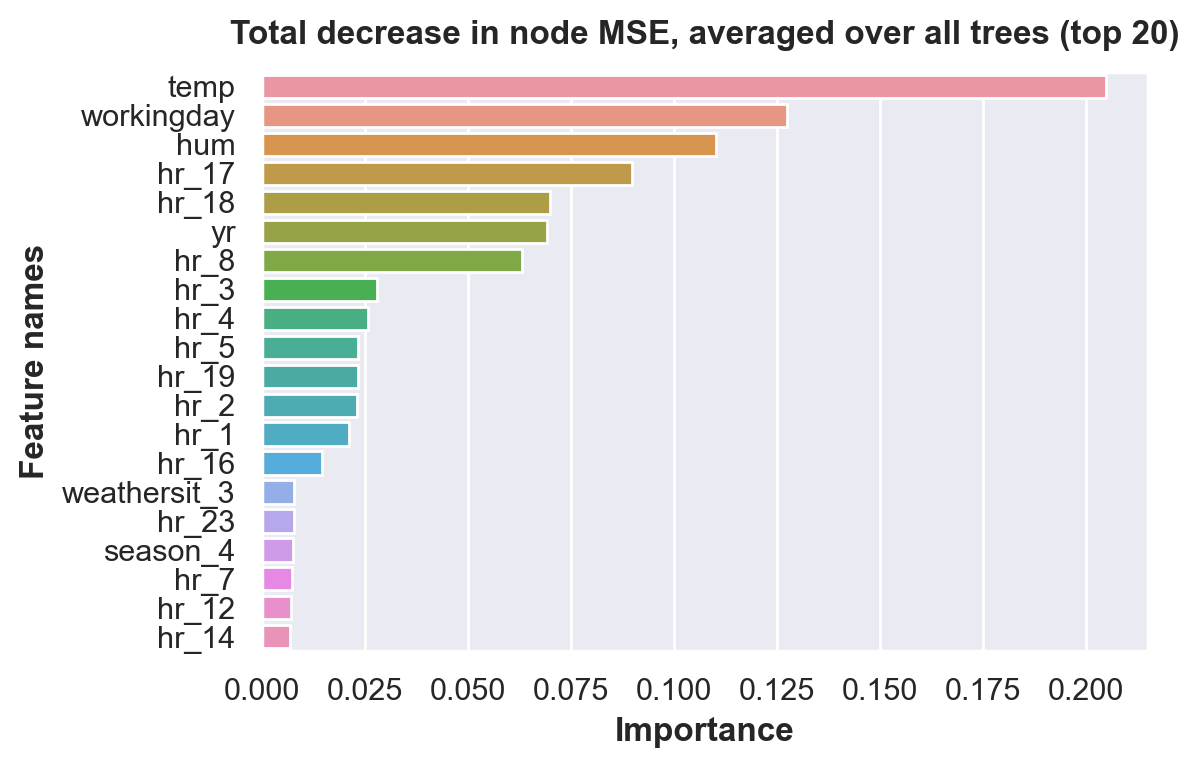

In [ ]:
# Plot feature importance
fig, ax =plt.subplots(figsize=(6,4))
ax=sns.barplot(x=feature_imp_gbr['importance'][:20], y=feature_imp_gbr['feature'][:20])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature names')
ax.set_title('Total decrease in node MSE, averaged over all trees (top 20)')

Insights:
- The feature importance derived from the average decrease in mse across all trees when building the gbr0 model are illustrated. The top 10 the most important features are: 'temp', 'workingday', 'hum', 'hr_17', 'hr_18', 'yr', 'hr_8','hr_3', 'hr_4', 'hr_5'.

# VI Model performance and interpretation

## VI.1 Model performance

In [ ]:
# Compute train and test predictions and plot 
y_test_pred_gbr = gbr0.predict(X_test_scaled)
y_train_pred_gbr = gbr0.predict(X_train_scaled)

[Text(0.5, 1.0, 'Out-sample predictions'),
 Text(0.5, 0, 'y_test'),
 Text(0, 0.5, 'y_test_pred')]

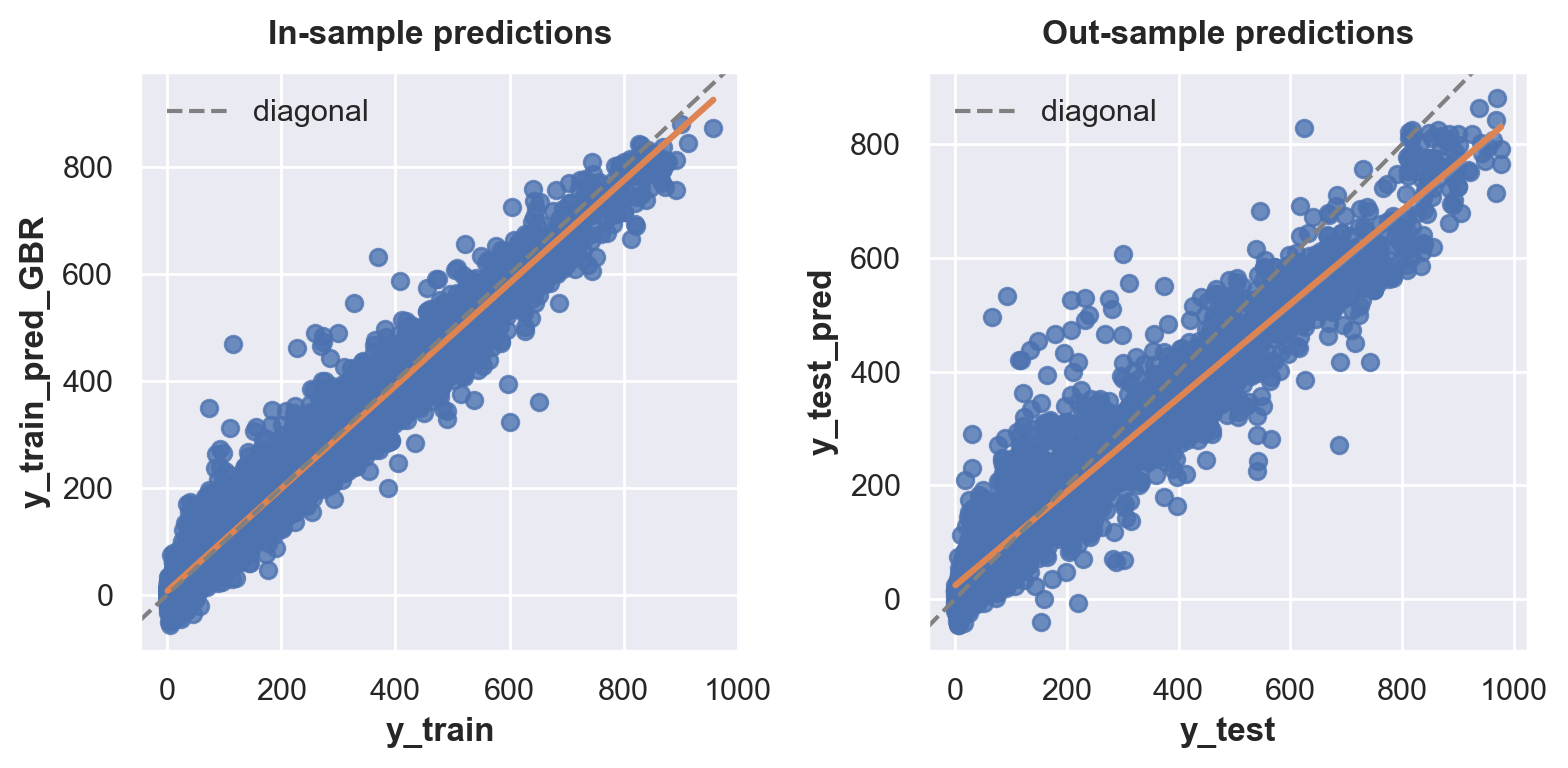

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

sns.regplot(x=y_train, y=y_train_pred_gbr, line_kws={'color': 'C1'}, ax=ax[0])
ax[0].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[0].legend(loc='upper left')
ax[0].set(title='In-sample predictions', xlabel='y_train', ylabel='y_train_pred_GBR')

sns.regplot(x=y_test, y=y_test_pred_gbr,line_kws={'color': 'C1'}, ax=ax[1])
ax[1].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[1].legend(loc='upper left')
ax[1].set(title='Out-sample predictions', xlabel='y_test', ylabel='y_test_pred')


In [ ]:
# Compute errors and plot 
error_train_gbr = y_train - y_train_pred_gbr
error_test_gbr = y_test - y_test_pred_gbr

[Text(0.5, 1.0, 'Out-sample Errors'), Text(0.5, 0, 'error')]

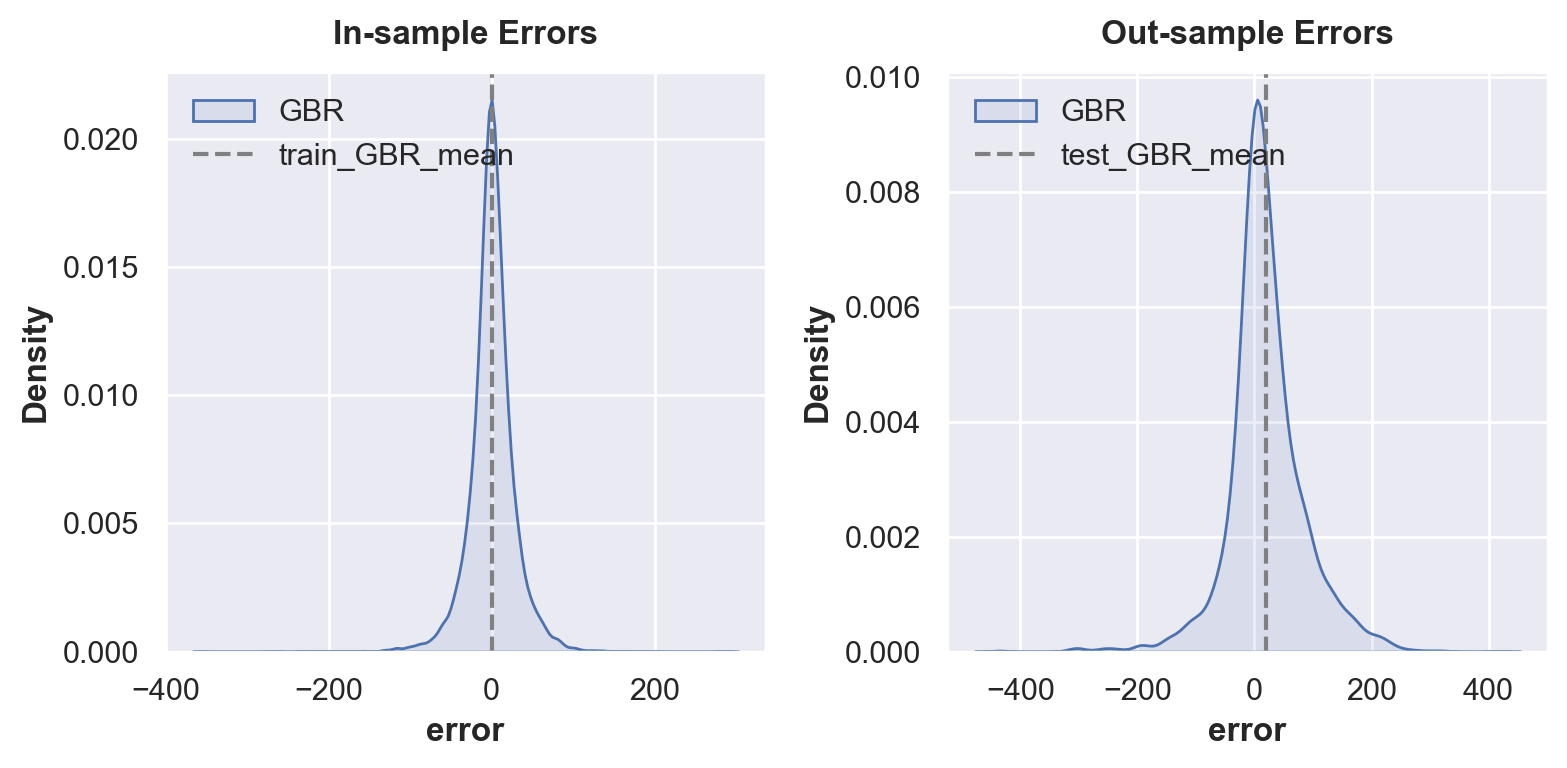

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

sns.kdeplot(x=error_train_gbr, label='GBR', fill=True, alpha=0.1, ax=ax[0])
ax[0].axvline(x=error_train_gbr.mean(), linestyle='--', color='gray', label='train_GBR_mean')
ax[0].legend(loc='upper left')
ax[0].set(title='In-sample Errors', xlabel='error')

sns.kdeplot(x=error_test_gbr, label='GBR', fill=True, alpha=0.1, ax=ax[1])
ax[1].axvline(x=error_test_gbr.mean(), color='gray', linestyle='--', label='test_GBR_mean')
ax[1].legend(loc='upper left')
ax[1].set(title='Out-sample Errors', xlabel='error')

Insights:
- gbr0 fits training data very well, but on testing data the model tends to be more and more under-forecasting (the actual values are more than the forecast values).
- The residuals are normally distributed as expected. But on test set, variance is greater and the distribution is slightly right skewed.

[Text(0.5, 1.0, 'In-sample predictions')]

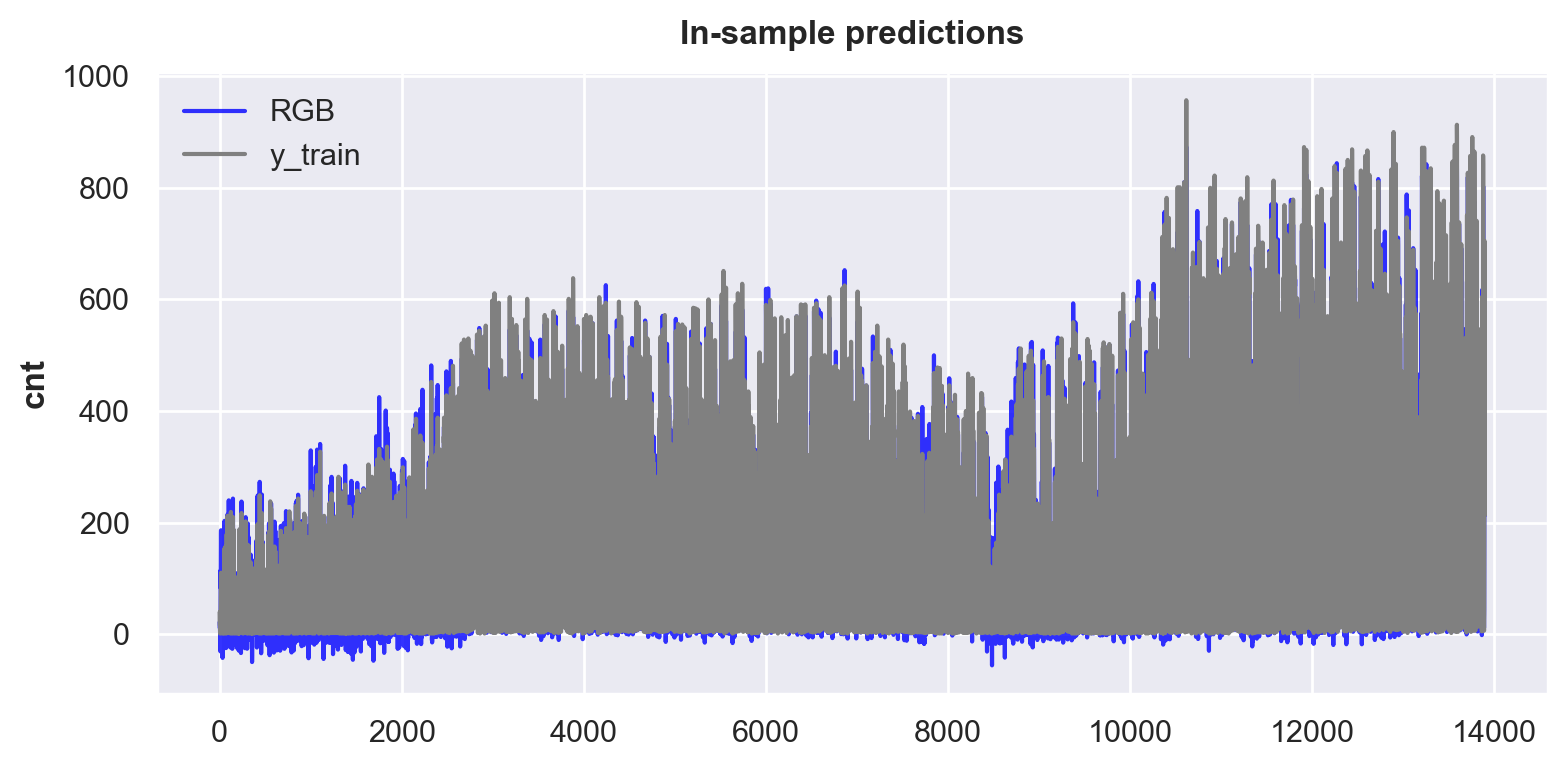

In [ ]:
# Visualize the predictions as a time series
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot( x=range(y_train_pred_gbr.shape[0]), y=y_train_pred_gbr, color='blue', label='RGB', alpha=0.8,ax=ax)
sns.lineplot(x=range(y_train.shape[0]), y=y_train, color='gray', label='y_train', ax=ax)
ax.set(title='In-sample predictions')

[Text(0.5, 1.0, 'Out-sample predictions')]

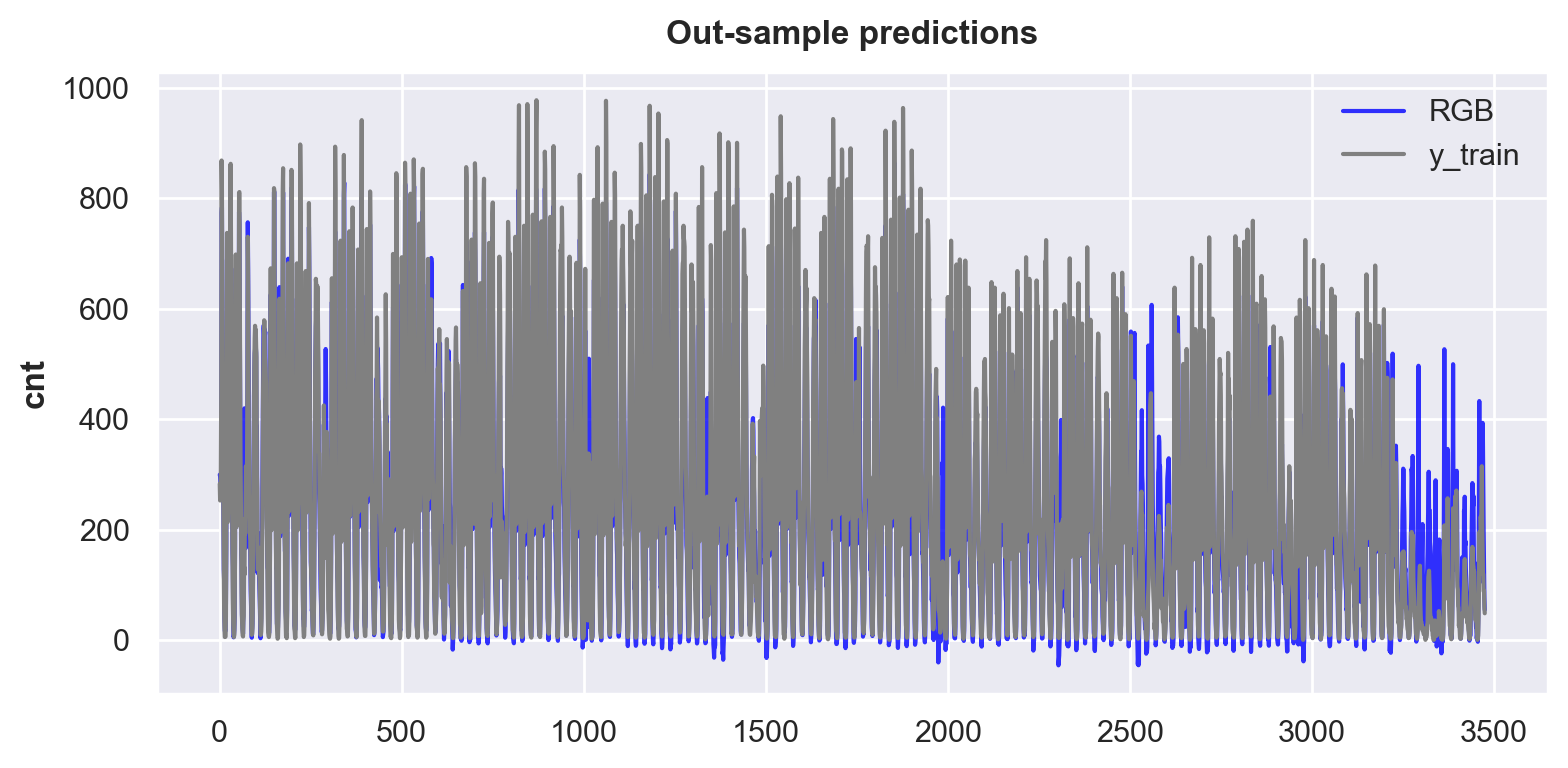

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
sns.lineplot( x=range(y_test_pred_gbr.shape[0]), y=y_test_pred_gbr, color='blue', label='RGB', alpha=0.8,ax=ax)
sns.lineplot(x=range(y_test.shape[0]), y=y_test, color='gray', label='y_train', ax=ax)
ax.set(title='Out-sample predictions')

In [ ]:
negatif_train_pred=len([i for i in y_train_pred_gbr if i<0])
percentage_neg_train_pred=negatif_train_pred/len(y_train_pred_gbr) 

negatif_test_pred=len([i for i in y_test_pred_gbr if i<0])
percentage_neg_test_pred=negatif_test_pred/len(y_test_pred_gbr) 

total_negatif=negatif_train_pred+negatif_test_pred

print(negatif_train_pred, percentage_neg_train_pred)
print(negatif_test_pred, percentage_neg_test_pred)
print(total_negatif)

585 0.04207724951449327
180 0.05178365937859609
765


Insights:
- Since we are predicting counts of user renting bike. These numbers should be positive. However, from 2 prediction plots,  we see some negative predictions (blue lines go below 0).
- In total, the model has predicted 765 negative values, which is around 5% of our full dataset.
- To overcome this problem, we can try and transform the target variable. We can take natural log of the target variable and then rebuild the model. But since we apply log onto the target variable, we need to use exponential function to get the correct final prediction.

## VI.2 Model interpretation

About SHAP (SHapley Additive exPlanations):
Shapley values are a widely used approach from cooperative game theory. The essence of Shapley value is to measure the contributions to the final outcome from each player separately among the coalition, while preserving the sum of contributions being equal to the final outcome. In machine learning, we use SHAP method to reply following questions:
- How do different features affect the prediction results.
- What are the top features that influence the prediction results.
- The model performance metrics look great, but should I trust the results?

In [ ]:
explainer = shap.TreeExplainer(gbr0)
shap_values = explainer.shap_values(X_test_scaled)

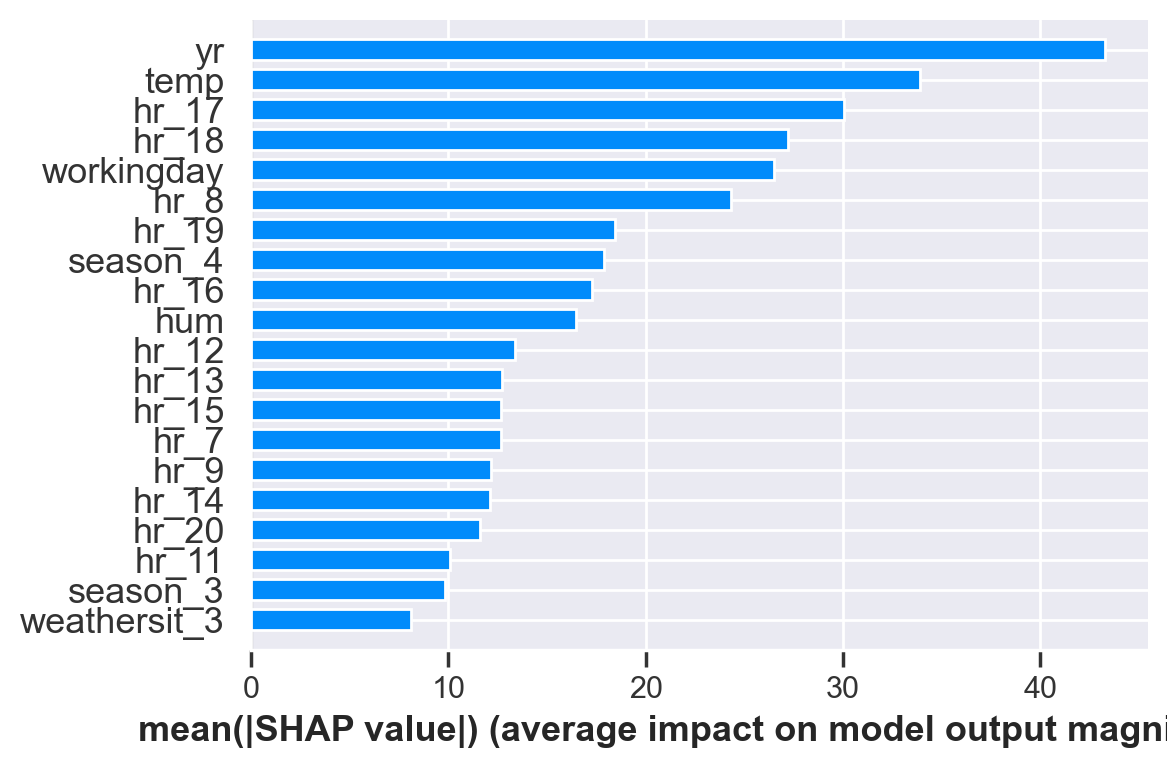

In [ ]:
shap.summary_plot(shap_values, X_test_scaled, max_display=20, plot_type='bar', color_bar='husl', plot_size=(6,4))

 Insights:
 - The feature importance based on magnitude of feature attributions on prediction illustrate the overall trend of feature impact. The features are ordered by how much they influenced the model’s prediction. The x-axis stands for the average of the absolute SHAP value of each feature. 
 - The top 10 the most important features which affect the outcome are: 'yr', 'temp', 'hr_17', 'hr_18', 'workingday', 'hr_8','hr_19', 'hr_16','season_4', 'hum'. 
 (note that the feature importance related to prediction is not exactly the same as the feature importance for building the model, but they are very similar.)

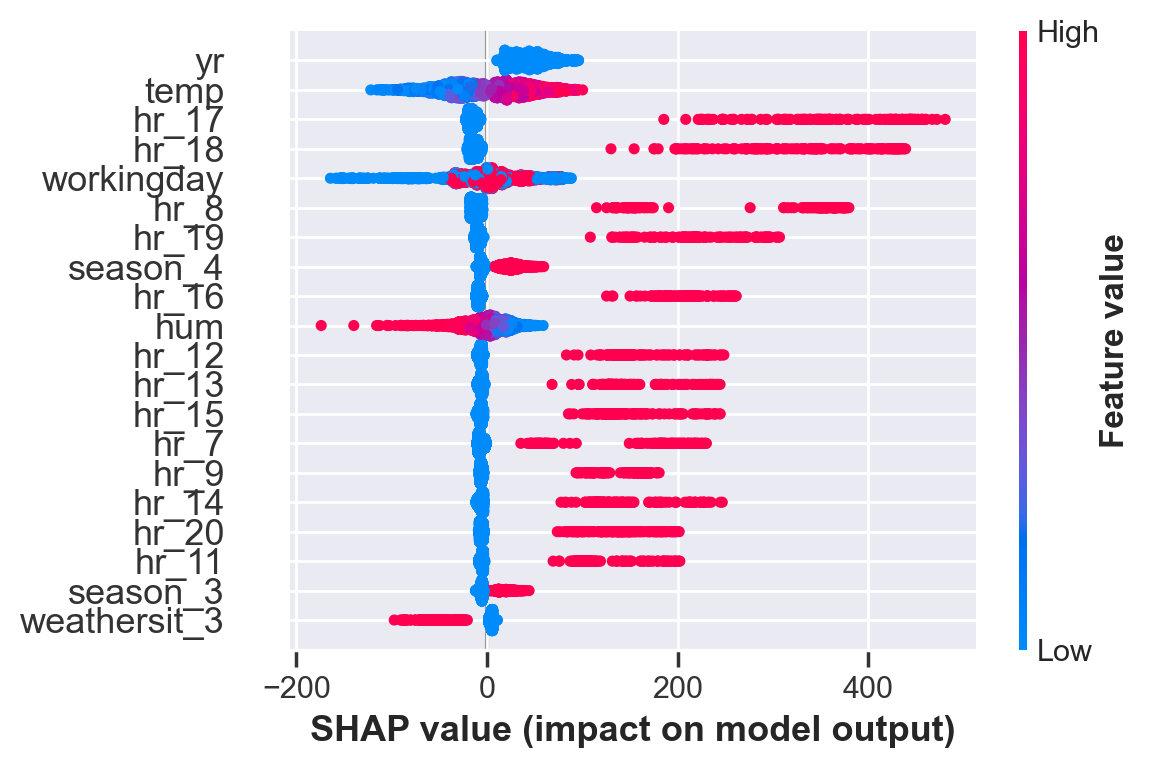

In [ ]:
shap.summary_plot(shap_values, X_test_scaled, max_display=20, plot_size=(6,4))

SHAP values also show whether the feature has a positive or negative impact on predictions. Positive SHAP value means positive impact on prediction. Negative SHAP value means negative impact. 

We can plot dot charts to visualize the directionality impact of the features. In this chart, the x-axis stands for SHAP value, and the y-axis has all the features. Each point on the chart is one SHAP value for a prediction and feature. Red color means higher value of a feature. Blue means lower value of a feature. We can get the general sense of features’ directionality impact based on the distribution of the red and blue dots.

Insights: 
- Higher value of hr_17, hr_18, hr_8, hr_19, hr_16 lead to higher rental count, with great magnitude. 
- season_4, season_3 and temp affect positively, but with moderate magnitude (red bar on right site but close to 0). 
- In contrast, higher value of  wheathersit and hum leads to lower rental number. 
- Caused by time series split, in test set year==1, thus we see only positive influence part of year.
<!-- Impact of workingday is not very clear (need to think more how to interpret it :).  -->


In [ ]:
# Adding matplotlib=True in the function works as well
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[108, :], X_test_scaled.iloc[101, :])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[908, :], X_test_scaled.iloc[908, :])

In [ ]:
# Uncomment following line to get information for the days iloc[101, :] and iloc[908, :]
# X_test.iloc[101, :]
# X_test.iloc[908, :]
y_test.iloc[101], y_test.iloc[908]


(512, 766)

Finally, let's look local interpretability by SHAP: We calculate SHAP values for 2 individual predictions selected randomly and see how the features contribute to that single prediction. 

Analyzing the instances that are correctly predicted and instances that are wrongly predicted just gives a sense of which features are leading to the right/wrong prediction in individual case. The base (average) value is mentioned and each feature’s contribution to the prediction is shown. Features indicating red contribute to the prediction being higher than base i.e. towards default, whereas features indicating blue contribute to the prediction being lower than base i.e. towards non-default

Insights: 
- The first prediction is for idex101 (yr=1, temp=0.74, hum=0.66, windspeed=0.3582, season_3=1.0, mnth_8=1.0, hr_17=1.0, weekday_6=1.0, weathersit_3=1.0). It is for 5pm of a saturday with bad weathersit in august. The value predicted is relatively low, 114.8. Year and season played important roles for prediction. The true number of bikers for that day is 512. Year, temperature and season_3 are dominant predictors.
-  The seconde prediction is for idex908 (yr=1, temp=0.6, hum=0.78, windspeed=0.0.1642, season_3=1.0, mnth_9=1.0, hr_8=1.0, weekday_5=1.0, weathersit_2=1.0). It is for 8am of a cloudy friday in september, the value predicted is 591.41. Year and season played important roles for prediction. The true number of bikers for that day is 766. Hour, year and workingday are dominant predictors.

- Overall, the model tends to underestimate the bikers, as we saw above in model performance part. However generally speaking, from model global view of SHAP values for each feature and individual instance view, model predictions is understandable and reasonable. 

In [ ]:
# save and load the model = pickle.load(open('gbr0/SharingBiersGBR_model.pkl','rb'))

with open('SharingBiersGBR_model.pkl', 'wb') as file:
    pickle.dump(gbr0, file)

# VII Conclusion and outlook

We performed an analysis on the growth in popularity of bike-share over the two years (2011–2012), the effect of the seasonal and day factors on the ridership patterns and the impacts of seasonal and weather parameters, to understand the ridership pattern in Washington, DC.

Via EDA, we can make the following observations:
- 80% of users are registered, probably they travel from home to work/study place on working days. 20% of users are casual. The take bikes more likely for leisure at the weekends and on holidays.
- The dominant influential factors on bike rentals are: year, temperature, hour 7–9am and 5–7pm, working day.
- Bike rentals tend to increasing.
- The summer and fall season exhibits the highest rental rates, whereas spring records the lowest. 
- June sees the highest number of bike rentals, while January marks the lowest.
- Clear weather and conditions correlate with higher bike rental numbers. 
- There is a week correlation between humidity, wind speed with bike rentals.
- Bike rentals tend to be lower during holidays and weekend. Conversely, bike rentals spike on working days.
- The peak rental hours are 7–9am and 5–7pm on working days.

Keeping these inferences in mind, we could suggest the following recommendations to optimize bike inventory and resources, ensuring that bike-sharing companies can meet customer demand and maximize revenue:
- Most of the rentals are for commuting to workshops on a daily basis. So we should launch more stations near these landmarks to reach out to their main customers.
- Planning for more sharing bikes to stations must consider the peak rental hours, i.e., 7–9 am and 5–7 pm.
- Due to the low usage of bikes at night, it would be better to do bike maintenance at night. Removing some bikes from the streets at night time will not cause trouble for the customers.
- Designing marketing strategies to maintain and expand the number of annual members, such as providing discounts and coupons for new registered users, offering users the convenience of renting and returning (app operation system for example), adding choice between mechanical and electric bikes to respond different needs.
- Designing marketing strategies to promote bike usage during the spring and winter. 

Apart from understanding influential factors, the seconde problem statement for bike-sharing demand analysis typically involves predicting bike rental demand. The company management needs forecasting models to understand the demand dynamics of the market and optimize bike allocation to improve the bike-sharing system’s efficiency and sustainability. 

Therefore, in this project, several models are built using techniques like regression analysis, time series analysis, and machine learning algorithms. The predictive model gbr0 displayed high global performance with low mse and high r2, but this model still need to be refined to improve forecasting accuracy and reliability. Meanwhile, other models like XGboost, deep learning CNN and so fore are worthy of trying as well.

Future data collection and analysis inspired: 
- Geography trip data analysis: trips taken and their duration and distance, starting and ending stations.
- Bike system finance analysis

All there analysis can be combined together, providing more complete and robust information and evidence for decision making. 

In [ ]:
# A method to evaluate feature importance in random forest:
# Add a random feature to the dataset and see if it gets a high importance score.
# The random feature acts as a benchmark against which the importance of the actual features.
# X_train_random = X_train.copy()
# X_train_random["RANDOM"] = np.random.RandomState(42).randn(X_train.shape[0])
# rf_random = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_random.fit(X_train_random, y_train)
# global_importances_random = pd.Series(rf_random.feature_importances_, index=X_train_random.columns)
# global_importances_random.sort_values(ascending=True, inplace=True)